Defining functions etc: 

In [59]:
#!/usr/bin/env python                                                                                                               
import numpy as np
from numpy import linalg as LA
import scipy as scipy
from scipy import interpolate
from scipy.integrate import quad
import os 
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, e, k
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

bright_colors = ['xkcd:blue', 'xkcd:orange','xkcd:green','xkcd:light blue','xkcd:light orange','xkcd:light green','xkcd:brown','xkcd:light brown'] # This is a part of the ColorBrewer Set1 palette



def readRDFs(inputlocation): 
    # Read the data into a DataFrame
    df = pd.read_csv(inputlocation, delim_whitespace=True, header=None)
    # Convert the DataFrame to a numpy array
    data = df.to_numpy(dtype="float64")
    return data

def Gxxint(f, rmin, rCO):
    def integrand(r):
        return 4 * np.pi * (f(r) - 1) * r**2.0
    Gpp, Gpperr = quad(integrand, rmin, rCO)
    return Gpp, Gpperr

def zerocalc(rval, RDFval, r_zero_start, r_zero_end):
    RDFfunc = interpolate.interp1d(rval, RDFval, kind='cubic')
    RDFfunczero, RDFfunczeroerror = quad(RDFfunc, r_zero_start, r_zero_end)
    RDFfunczero = RDFfunczero / (r_zero_end - r_zero_start)
    return RDFfunczero

def normf(rval, RDFval, RDFfunczero):
    RDFvalnormed = [x / RDFfunczero for x in RDFval]
    return interpolate.interp1d(rval, RDFvalnormed, kind='cubic')

def KBcalc(r2p5M, LiLi, LiCl, ClCl, LiO, ClO, rmin, rCO, rhoC):
    LiLif = interpolate.interp1d(r2p5M, LiLi, kind='cubic')
    LiClf = interpolate.interp1d(r2p5M, LiCl, kind='cubic')
    ClClf = interpolate.interp1d(r2p5M, ClCl, kind='cubic')
    LiOf = interpolate.interp1d(r2p5M, LiO, kind='cubic')
    ClOf = interpolate.interp1d(r2p5M, ClO, kind='cubic')

    Gpp, Gpperr = Gxxint(LiLif, rmin, rCO)
    Gpn, Gpnerr = Gxxint(LiClf, rmin, rCO)
    Gnn, Gnnerr = Gxxint(ClClf, rmin, rCO)
    Gpo, Gpoerr = Gxxint(LiOf, rmin, rCO)
    Gno, Gnoerr = Gxxint(ClOf, rmin, rCO)

    Gco = (Gno + Gpo) / 2
    Gcc = .5**2 * Gpp + .5**2 * Gnn + 2 * .5**2 * Gpn
    return 1 / (1 + 2 * rhoC * (Gcc - Gco))

#def KBcalcCG(r2p5MCG, LiLi, LiCl, ClCl, r2p5M, LiO, ClO, rmin, rCO, rhoC):
#    LiLif = interpolate.interp1d(r2p5MCG, LiLi, kind='cubic')
#    LiClf = interpolate.interp1d(r2p5MCG, LiCl, kind='cubic')
#    ClClf = interpolate.interp1d(r2p5MCG, ClCl, kind='cubic')
#    LiOf = interpolate.interp1d(r2p5M, LiO, kind='cubic')
#    ClOf = interpolate.interp1d(r2p5M, ClO, kind='cubic')

#    Gpp, Gpperr = Gxxint(LiLif, rmin, rCO)
#    Gpn, Gpnerr = Gxxint(LiClf, rmin, rCO)
#    Gnn, Gnnerr = Gxxint(ClClf, rmin, rCO)
#    Gpo, Gpoerr = Gxxint(LiOf, rmin, rCO)
#    Gno, Gnoerr = Gxxint(ClOf, rmin, rCO)

#    Gco = (Gno + Gpo) / 2
#    Gcc = .25 * (2.0 * Gpn + Gpp + Gnn)

#    return 1 / (1 + 2 * rhoC * (Gcc - Gco))


def set_plot_style(ax=None):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 32
    plt.tight_layout()
    if ax is None:
        ax = plt.gca()  # get the current axes if not provided
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', which='major', labelsize=24, length=10, width=3)


Computing LiCL KB integrals at 2.5M

In [60]:

L = 25.26
rCO = L / 2.0
NIon = 24
Boxsize = (L * 10**-10)**3
rhoC = NIon / Boxsize * 10**-30
#These are kept the same as above for consistency
rmin = 0.005
zeroRange = 2

RDFLiCl2p5Mar1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3-bigbox-2p4M-run1.dat"))
RDFLiCl2p5Mar2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3-bigbox-2p4M-run2.dat"))
RDFLiCl2p5Mbr1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3b-bigbox-2p4M-run1.dat"))
RDFLiCl2p5Mbr2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3b-bigbox-2p4M-run2.dat"))

RDFarr2p5 = np.dstack((RDFLiCl2p5Mar1, RDFLiCl2p5Mar2, RDFLiCl2p5Mbr1, RDFLiCl2p5Mbr2))

n = RDFarr2p5.shape[2]

r2p5M = RDFarr2p5[:, 0, 0]

# Slicing the array: all elements in the first dimension, last 7 in the second, all in the third
RDFarr2p5 = RDFarr2p5[:, 1:, :]

# Averaging over the last dimension
RDFarr_av_2p5 = np.mean(RDFarr2p5, axis=2)

# Reshape array2 to (1501, 7, 1)
RDFarr_av_2p5 = RDFarr_av_2p5[:, :, np.newaxis]
print(np.shape(RDFarr_av_2p5))

# Stack the arrays to get a shape of (1501, 7, 5)
RDFarr2p5 = np.concatenate((RDFarr2p5, RDFarr_av_2p5), axis=2)

r_zero_start = rCO - zeroRange
r_zero_end = rCO + zeroRange

zeros2p5 = np.array([[zerocalc(r2p5M, RDFarr2p5[:, j, i], r_zero_start, r_zero_end) for i in range(n + 1)] for j in range(7)])
RDFarrnorm2p5 = RDFarr2p5 / zeros2p5
TheoryKBnorm = np.array([KBcalc(r2p5M, RDFarrnorm2p5[:, 0, i], RDFarrnorm2p5[:, 1, i], RDFarrnorm2p5[:, 2, i], RDFarrnorm2p5[:, 3, i], RDFarrnorm2p5[:, 4, i], rmin, rCO, rhoC) for i in range(n + 1)])

print("KB pred with normed RDF:", TheoryKBnorm)
std_dev = np.std(TheoryKBnorm[0:n], ddof=1)
std_error = std_dev / np.sqrt(n)
print("Standard error:", std_error)

TheoryKBnorm2p5MLiCl = TheoryKBnorm[n]
TheoryKBnorm2p5MerrLiCl = std_error


(1501, 7, 1)


/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  RDFfunczero, RDFfunczeroerror = quad(RDFfunc, r_zero_start, r_zero_end)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one w

KB pred with normed RDF: [1.60708711 1.32039691 2.23279202 1.91586797 1.69893536]
Standard error: 0.19666675601611752


 Making Li dimer inset plot:

/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


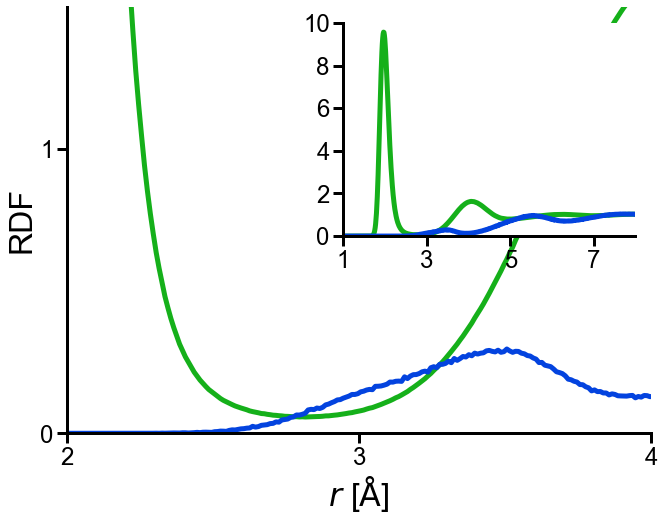

In [61]:
# Create the main plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(r2p5M, RDFarrnorm2p5[:, 3, 4], label='Li-O', linewidth=5, color=bright_colors[2])
ax.plot(r2p5M, RDFarrnorm2p5[:, 0, 4], label='Li-Li', linewidth=5, color=bright_colors[0])
ax.set_xlim([2, 4])
ax.set_ylim([0, 1.5])
ax.set_xticks(np.arange(2.0, 4.01, 1))
ax.set_yticks(np.arange(0, 1.01, 1))
ax.set_xlabel('$r$ [$\mathrm{\\AA}$]', fontsize=32)
ax.set_ylabel('RDF', fontsize=32)
# ax.legend(loc='best', fontsize=24, frameon=False)

# Apply the style settings to the main plot
set_plot_style(ax)

# Create the inset plot
axins = inset_axes(ax, width='50%', height='50%', loc='upper right')
axins.plot(r2p5M, RDFarrnorm2p5[:, 3, 4], linewidth=5, color=bright_colors[2], label='Li-O')
axins.plot(r2p5M, RDFarrnorm2p5[:, 0, 4], linewidth=5, color=bright_colors[0], label='Li-Li')
axins.set_xlim([1, 8])
axins.set_ylim([0, 10])
axins.set_xticks(np.arange(1, 8.01, 2))
axins.set_yticks(np.arange(0, 10.01, 2))
axins.set_xlabel('$r$ [$\mathrm{\\AA}$]', fontsize=24)
axins.set_ylabel('RDF', fontsize=24)

axins.set_xlabel('')
axins.set_ylabel('')
axins.tick_params(axis='both', which='both', labelsize=0, length=0)  # Remove tick labels and tick marks

# Apply the style settings to the inset plot
set_plot_style(axins)

# Save the figure
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiLiLiO.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    


Making LiCl RDFs

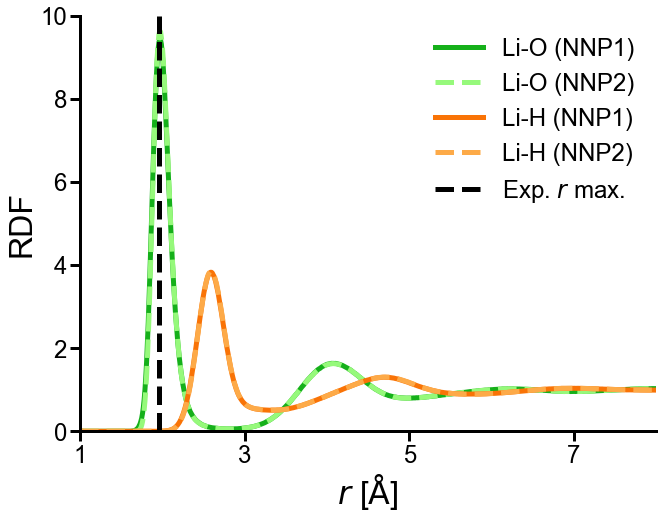

In [62]:

plt.figure(figsize=(10, 8))
plt.plot(r2p5M, RDFarrnorm2p5[:,3,0], label='Li-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(r2p5M, RDFarrnorm2p5[:,3,2], label='Li-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(r2p5M, RDFarrnorm2p5[:,5,0], label='Li-H (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(r2p5M, RDFarrnorm2p5[:,5,2], label='Li-H (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.axvline(x=1.96, color='black', linestyle='--', label='Exp. $r$ max.', linewidth=5)
plt.xlim([1, 8])
plt.ylim([0, 10])
# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,10.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()





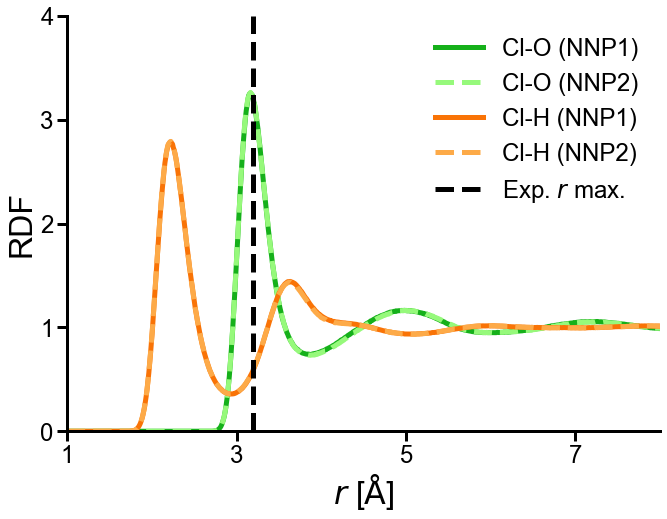

In [63]:

plt.figure(figsize=(10, 8))
plt.plot(r2p5M, RDFarrnorm2p5[:,4,0], label='Cl-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(r2p5M, RDFarrnorm2p5[:,4,2], label='Cl-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(r2p5M, RDFarrnorm2p5[:,6,0], label='Cl-H (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(r2p5M, RDFarrnorm2p5[:,6,2], label='Cl-H (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.axvline(x=3.2, color='black', linestyle='--', label='Exp. $r$ max.', linewidth=5)


plt.xlim([1, 8])
plt.ylim([0, 4])
# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFClwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()



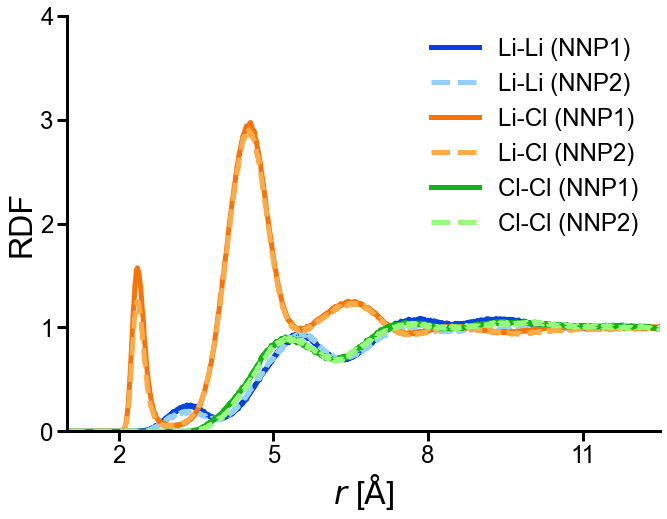

In [64]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(r2p5M, RDFarrnorm2p5[:,0,1], label='Li-Li (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(r2p5M, RDFarrnorm2p5[:,0,2], label='Li-Li (NNP2)', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(r2p5M, RDFarrnorm2p5[:,1,1], label='Li-Cl (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(r2p5M, RDFarrnorm2p5[:,1,2], label='Li-Cl (NNP2)', linewidth=5, color=bright_colors[4],linestyle='--')
plt.plot(r2p5M, RDFarrnorm2p5[:,2,1], label='Cl-Cl (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(r2p5M, RDFarrnorm2p5[:,2,2], label='Cl-Cl (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 4])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiCll32p5M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

Computing 1.2 M LiCl KB integrals

In [65]:
L=25.05
rCO = L/2.0
NIon = 12
Boxsize = (L*10**-10)**3
rhoC=NIon/Boxsize*10**-30
#These are kept the same as above for consistency
#rmin = 0.005
#zeroRange = 2


RDFLiCl1p2Mar1=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3-bigbox-1p2M-run1.dat"))
RDFLiCl1p2Mar2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3-bigbox-1p2M-run2.dat"))
RDFLiCl1p2Mbr1=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3b-bigbox-1p2M-run1.dat"))
RDFLiCl1p2Mbr2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiCl-out.lammpstrj-l3b-bigbox-1p2M-run2.dat"))

RDFarr1p2=np.dstack((RDFLiCl1p2Mar1, RDFLiCl1p2Mar2 ,RDFLiCl1p2Mbr1 ,RDFLiCl1p2Mbr2))

n=RDFarr1p2.shape[2]

r1p2M= RDFarr1p2[:, 0, 0]

# Slicing the array: all elements in the first dimension, last 7 in the second, all in the third
RDFarr1p2 = RDFarr1p2[:, 1:, :]

# Averaging over the last dimension
RDFarr_av_1p2 = np.mean(RDFarr1p2, axis=2)

# Reshape array2 to (1501, 7, 1)
RDFarr_av_1p2 = RDFarr_av_1p2[:, :, np.newaxis]
print(np.shape(RDFarr_av_1p2))

# Stack the arrays to get a shape of (1501, 7, 5)
RDFarr1p2 = np.concatenate((RDFarr1p2, RDFarr_av_1p2), axis=2)

r_zero_start=rCO-zeroRange
r_zero_end=rCO+zeroRange


TheoryKB=np.array([KBcalc(r1p2M, RDFarr1p2[:,0,i], RDFarr1p2[:,1,i], RDFarr1p2[:,2,i], RDFarr1p2[:,3,i], RDFarr1p2[:,4,i],rmin,rCO,rhoC) for i in range(n+1)]) 

zeros1p2=np.array([[zerocalc(r1p2M,RDFarr1p2[:,j,i],r_zero_start, r_zero_end) for i in range(n+1)] for j in range(7)])
RDFarrnorm1p2=RDFarr1p2/zeros1p2
TheoryKBnorm=np.array([KBcalc(r1p2M, RDFarrnorm1p2[:,0,i], RDFarrnorm1p2[:,1,i], RDFarrnorm1p2[:,2,i], RDFarrnorm1p2[:,3,i], RDFarrnorm1p2[:,4,i],rmin,rCO,rhoC) for i in range(n+1)]) 


print("KB pred with normed RDF:",+TheoryKBnorm)
std_dev = np.std(TheoryKBnorm[0:n], ddof=1)
std_error = std_dev / np.sqrt(n)
print("Standard error:",+std_error)

TheoryKBnorm1p2MLiCl=TheoryKBnorm[n]
TheoryKBnorm1p2MerrLiCl=std_error

(1501, 7, 1)


/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gpp, Gpperr = quad(integrand, rmin, rCO)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Gpp, Gpperr = quad(integrand, rmin, rCO)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it 

KB pred with normed RDF: [0.91213585 1.45651122 0.97155162 1.50167208 1.14871808]
Standard error: 0.15583650298543245


More RDFs

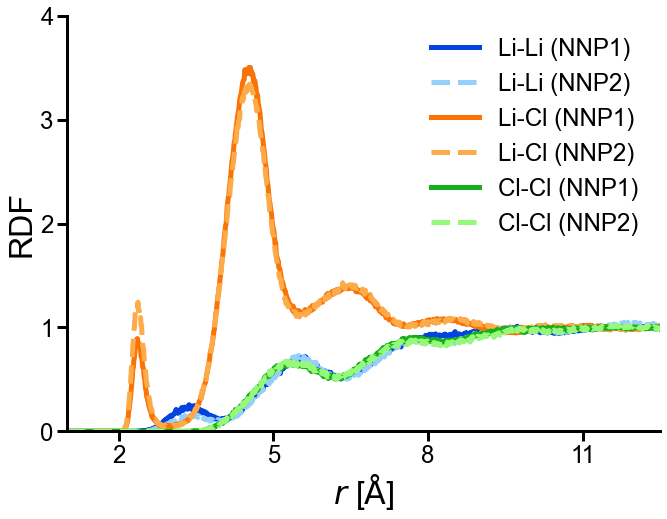

In [66]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(r1p2M, RDFarrnorm1p2[:,0,1], label='Li-Li (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(r1p2M, RDFarrnorm1p2[:,0,3], label='Li-Li (NNP2)', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(r1p2M, RDFarrnorm1p2[:,1,1], label='Li-Cl (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(r1p2M, RDFarrnorm1p2[:,1,3], label='Li-Cl (NNP2)', linewidth=5, color=bright_colors[4],linestyle='--')
plt.plot(r1p2M, RDFarrnorm1p2[:,2,1], label='Cl-Cl (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(r1p2M, RDFarrnorm1p2[:,2,3], label='Cl-Cl (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 4])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()   


plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiCll31p2M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

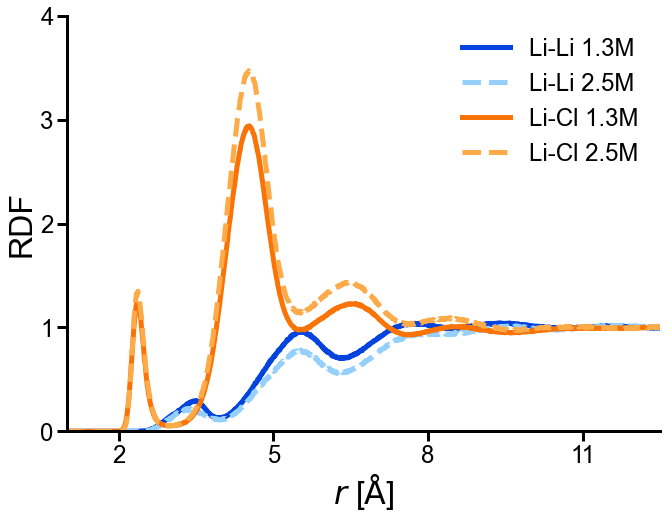

In [67]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(r2p5M, RDFarrnorm2p5[:,0,4], label='Li-Li 1.3M', linewidth=5, color=bright_colors[0])
plt.plot(r2p5M, RDFarrnorm1p2[:,0,4], label='Li-Li 2.5M', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(r2p5M, RDFarrnorm2p5[:,1,4], label='Li-Cl 1.3M', linewidth=5, color=bright_colors[1])
plt.plot(r2p5M, RDFarrnorm1p2[:,1,4], label='Li-Cl 2.5M', linewidth=5, color=bright_colors[4],linestyle='--')
#plt.plot(r2p5M, RDFarrnorm2p5[:,2,4], label='Cl-Cl (NNP1)', linewidth=5, color=bright_colors[2])
#plt.plot(r2p5M, RDFarrnorm2p5[:,2,4], label='Cl-Cl (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')
# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 4])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()    

plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiCll31p2Mvs2p4M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

KB integrals of KCl at 6.6 M. Note this is a smaller box size. But same definintion is used. Only two runs were used as these converge more quickly due to higher concentration.

In [68]:
L=14.47
rCO = L/2.0
NIon = 12
Boxsize = (L*10**-10)**3
rhoC=NIon/Boxsize*10**-30
#These are kept the same as above for consistency
#rmin = 0.005
#zeroRange = 2


#Dropping first run as there's an error in the KK RDF.
RDFkc36p6M=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3-6p6M.dat"))
RDFkc46p6M=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc4-6p6M.dat"))

#RDFarr2p5=np.dstack((RDFLiCl2p5Mar1, RDFLiCl2p5Mar2 ,RDFLiCl2p5Mbr1 ,RDFLiCl2p5Mbr2))
RDFarrKCl6p6=np.dstack((RDFkc36p6M,RDFkc46p6M ))
n=RDFarrKCl6p6.shape[2]

rKCl6p6M= RDFarrKCl6p6[:, 0, 0]

# Slicing the array: all elements in the first dimension, last 7 in the second, all in the third
RDFarrKCl6p6 = RDFarrKCl6p6[:, 1:, :]

# Averaging over the last dimension
RDFarr_av_KCl6p6 = np.mean(RDFarrKCl6p6, axis=2)

# Reshape array2 to (1501, 7, 1)
RDFarr_av_KCl6p6 = RDFarr_av_KCl6p6[:, :, np.newaxis]

# Stack the arrays to get a shape of (1501, 7, 5)
RDFarrKCl6p6 = np.concatenate((RDFarrKCl6p6, RDFarr_av_KCl6p6), axis=2)

r_zero_start=rCO-zeroRange
r_zero_end=rCO+zeroRange

zerosKCl6p6=np.array([[zerocalc(rKCl6p6M,RDFarrKCl6p6[:,j,i],r_zero_start, r_zero_end) for i in range(n+1)] for j in range(7)])


RDFarrnormKCl6p6=RDFarrKCl6p6/zerosKCl6p6

TheoryKB=np.array([KBcalc(rKCl6p6M, RDFarrKCl6p6[:,0,i], RDFarrKCl6p6[:,1,i], RDFarrKCl6p6[:,2,i], RDFarrKCl6p6[:,3,i], RDFarrKCl6p6[:,4,i],rmin,rCO,rhoC) for i in range(n+1)]) 
TheoryKBnorm=np.array([KBcalc(rKCl6p6M, RDFarrnormKCl6p6[:,0,i], RDFarrnormKCl6p6[:,1,i], RDFarrnormKCl6p6[:,2,i], RDFarrnormKCl6p6[:,3,i], RDFarrnormKCl6p6[:,4,i],rmin,rCO,rhoC) for i in range(n+1)]) 



print("KB pred with normed RDF:",+TheoryKBnorm)
std_dev = np.std(TheoryKBnorm[0:n], ddof=1)
std_error = std_dev / np.sqrt(n)
print("Standard error:",+std_error)

TheoryKBnorm6p6MKCl=TheoryKBnorm[n]
TheoryKBnorm6p6MerrKCl=std_error

/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  RDFfunczero, RDFfunczeroerror = quad(RDFfunc, r_zero_start, r_zero_end)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one w

KB pred with normed RDF: [1.63756433 1.33427398 1.47306289]
Standard error: 0.1516451782095385


More RDFs

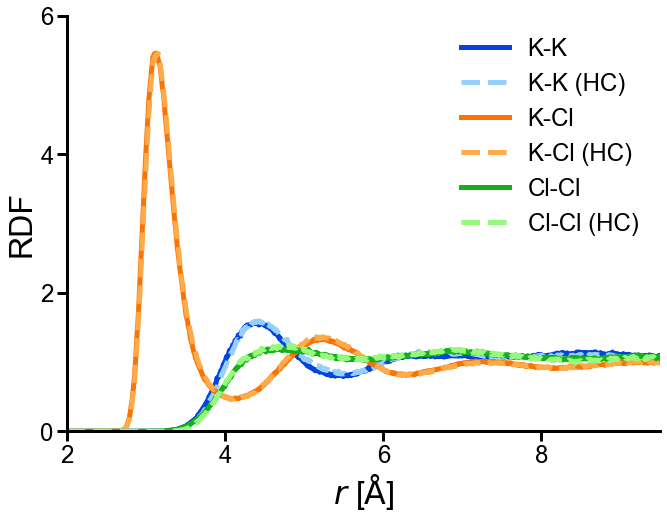

In [69]:

RDFkc36p6M=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3-6p6M.dat"))
RDFkc46p6M=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc4-6p6M.dat"))


# Plotting
plt.figure(figsize=(10, 8))
plt.plot(RDFkc36p6M[:,0], RDFkc36p6M[:,1], label='K-K',  linewidth=5, color=bright_colors[0])
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,1], label='K-K (HC)', linestyle='--', linewidth=5, color=bright_colors[3])
plt.plot(RDFkc36p6M[:,0], RDFkc36p6M[:,2], label='K-Cl',  linewidth=5, color=bright_colors[1])
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,2], label='K-Cl (HC)', linestyle='--', linewidth=5, color=bright_colors[4])
plt.plot(RDFkc36p6M[:,0], RDFkc36p6M[:,3], label='Cl-Cl',  linewidth=5, color=bright_colors[2])
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,3], label='Cl-Cl (HC)', linestyle='--', linewidth=5, color=bright_colors[5])

# Axis ticks
plt.xlim([2, 9.5])
plt.ylim([0, 6])
plt.xticks(np.arange(2,9.01, 2))
plt.yticks(np.arange(0,6.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style() 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFKCll6p6M-HCtraincomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()





KCl KB integrals at 2.5 M: 

In [70]:
L = 25.46
rCO = L / 2.0
NIon = 24
Boxsize = (L * 10**-10)**3
rhoC = NIon / Boxsize * 10**-30
#These are kept the same as above for consistency
#rmin = 0.005
#zeroRange = 2


RDFKCl2p5Mar1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3-bigbox-2p4M-run1.dat"))
RDFKCl2p5Mar2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3-bigbox-2p4M-run2.dat"))
RDFKCl2p5Mbr1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3b-bigbox-2p4M-run1.dat"))
RDFKCl2p5Mbr2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_KCl-out.lammpstrj-kc3b-bigbox-2p4M-run2.dat"))

RDFarrKCl2p5 = np.dstack((RDFKCl2p5Mar1, RDFKCl2p5Mar2, RDFKCl2p5Mbr1, RDFKCl2p5Mbr2))

n = RDFarrKCl2p5.shape[2]

rKCl2p5M = RDFarrKCl2p5[:, 0, 0]

# Slicing the array: all elements in the first dimension, last 7 in the second, all in the third
RDFarrKCl2p5 = RDFarrKCl2p5[:, 1:, :]

# Averaging over the last dimension
RDFarr_av_KCl2p5 = np.mean(RDFarrKCl2p5, axis=2)

# Reshape array to (1501, 7, 1)
RDFarr_av_KCl2p5 = RDFarr_av_KCl2p5[:, :, np.newaxis]

# Stack the arrays to get a shape of (1501, 7, 5)
RDFarrKCl2p5 = np.concatenate((RDFarrKCl2p5, RDFarr_av_KCl2p5), axis=2)

r_zero_start = rCO - zeroRange
r_zero_end = rCO + zeroRange

zerosKCl2p5 = np.array([[zerocalc(rKCl2p5M, RDFarrKCl2p5[:, j, i], r_zero_start, r_zero_end) for i in range(n + 1)] for j in range(7)])

RDFarrnormKCl2p5 = RDFarrKCl2p5 / zerosKCl2p5

TheoryKBnorm = np.array([KBcalc(rKCl2p5M, RDFarrnormKCl2p5[:, 0, i], RDFarrnormKCl2p5[:, 1, i], RDFarrnormKCl2p5[:, 2, i], RDFarrnormKCl2p5[:, 3, i], RDFarrnormKCl2p5[:, 4, i], rmin, rCO, rhoC) for i in range(n + 1)])

print("KB pred with normed RDF:", TheoryKBnorm)
std_dev = np.std(TheoryKBnorm[0:n], ddof=1)
std_error = std_dev / np.sqrt(n)
print("Standard error:", std_error)

TheoryKBnorm2p5MKCl = TheoryKBnorm[n]
TheoryKBnorm2p5MerrKCl = std_error

/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  RDFfunczero, RDFfunczeroerror = quad(RDFfunc, r_zero_start, r_zero_end)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one w

KB pred with normed RDF: [0.78035612 0.87424216 1.06307796 0.89154368 0.89162429]
Standard error: 0.05889454020818882


RDFs

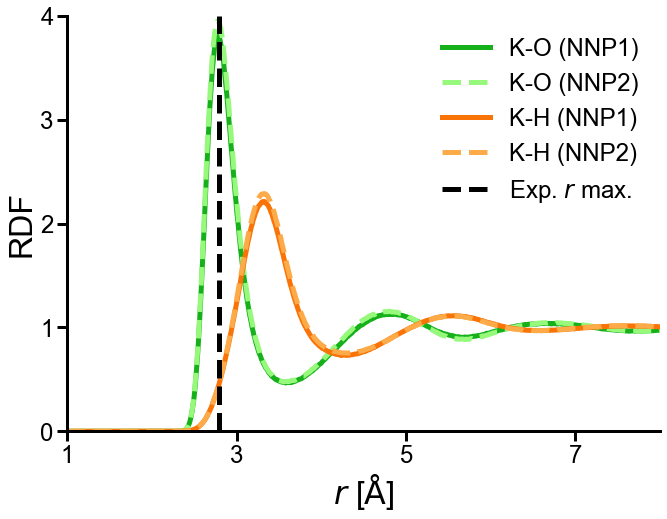

In [71]:

plt.figure(figsize=(10, 8))
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,3,0], label='K-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,3,2], label='K-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,5,0], label='K-H (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,5,2], label='K-H (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.axvline(x=2.79, color='black', linestyle='--', label='Exp. $r$ max.', linewidth=5)


plt.xlim([1, 8])
plt.ylim([0, 4])
# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()


plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFKwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()



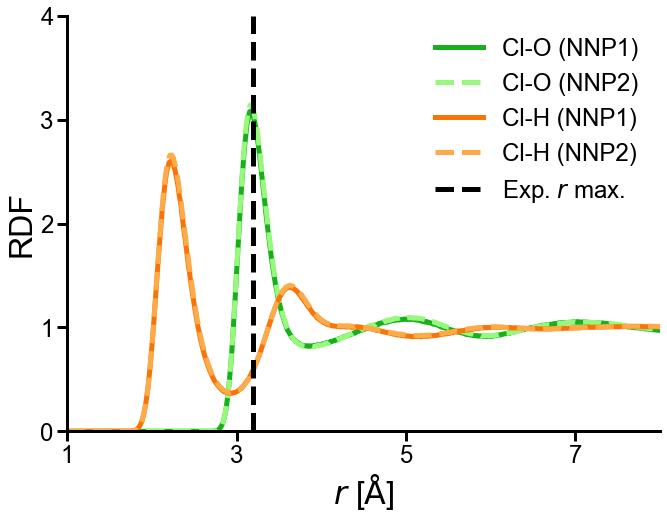

In [72]:

plt.figure(figsize=(10, 8))
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,4,0], label='Cl-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,4,2], label='Cl-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,6,0], label='Cl-H (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,6,2], label='Cl-H (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.axvline(x=3.2, color='black', linestyle='--', label='Exp. $r$ max.', linewidth=5)


plt.xlim([1, 8])
plt.ylim([0, 4])
# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFClKClwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


Now KB integrals for LiBr, some of these runs have less statistics so I have dividied one longer run up into a few to give 6 runs of equivalent length. 

In [73]:
L = 25.39
rCO = L / 2.0
NIon = 24
Boxsize = (L * 10**-10)**3
rhoC = NIon / Boxsize * 10**-30
#These are kept the same as above for consistency
#rmin = 0.005
#zeroRange = 2

# Splitting the first run into three so it is approximately the same length as the others to estimate uncertainty. 
RDFLiBr2p5Marunr1r1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3-run1-r1.dat"))
RDFLiBr2p5Mar1r2r3 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3-r2-r3.dat"))
RDFLiBr2p5Mar1r4r5r6 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3-r4-r5-r6.dat"))
RDFLiBr2p5Mar2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3-run2.dat"))
RDFLiBr2p5Mbr1 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3b-run1.dat"))
RDFLiBr2p5Mbr2 = readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/rdf_data_LiBr-out.lammpstrj-lb3b-run2.dat"))

distances = RDFLiBr2p5Marunr1r1[:, 0]

RDFarrLiBr2p5 = np.dstack((RDFLiBr2p5Marunr1r1, RDFLiBr2p5Mar1r2r3, RDFLiBr2p5Mar1r4r5r6, RDFLiBr2p5Mar2, RDFLiBr2p5Mbr1, RDFLiBr2p5Mbr2))

n = RDFarrLiBr2p5.shape[2]

rLiBr2p5M = RDFarrLiBr2p5[:, 0, 0]

# Slicing the array: all elements in the first dimension, last 7 in the second, all in the third
RDFarrLiBr2p5 = RDFarrLiBr2p5[:, 1:, :]

# Averaging over the last dimension
RDFarr_av_LiBr2p5 = np.mean(RDFarrLiBr2p5, axis=2)

# Reshape array to (1501, 7, 1)
RDFarr_av_LiBr2p5 = RDFarr_av_LiBr2p5[:, :, np.newaxis]

# Stack the arrays to get a shape of (1501, 7, 7)
RDFarrLiBr2p5 = np.concatenate((RDFarrLiBr2p5, RDFarr_av_LiBr2p5), axis=2)

r_zero_start = rCO - zeroRange
r_zero_end = rCO + zeroRange

zerosLiBr2p5 = np.array([[zerocalc(rLiBr2p5M, RDFarrLiBr2p5[:, j, i], r_zero_start, r_zero_end) for i in range(n + 1)] for j in range(7)])

RDFarrnormLiBr2p5 = RDFarrLiBr2p5 / zerosLiBr2p5

TheoryKBnorm = np.array([KBcalc(rLiBr2p5M, RDFarrnormLiBr2p5[:, 0, i], RDFarrnormLiBr2p5[:, 1, i], RDFarrnormLiBr2p5[:, 2, i], RDFarrnormLiBr2p5[:, 3, i], RDFarrnormLiBr2p5[:, 4, i], rmin, rCO, rhoC) for i in range(n + 1)])

print("KB pred with normed RDF:", TheoryKBnorm)
std_dev = np.std(TheoryKBnorm[0:n], ddof=1)
std_error = std_dev / np.sqrt(n)
print("Standard error:", std_error)

TheoryKBnorm2p5MLiBr = TheoryKBnorm[n]
TheoryKBnorm2p5MerrLiBr = std_error

/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  RDFfunczero, RDFfunczeroerror = quad(RDFfunc, r_zero_start, r_zero_end)
/var/folders/gb/mvyy1vgn4qx26_5vbxsfkgyh0000gq/T/ipykernel_40131/1190031889.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one w

KB pred with normed RDF: [1.57112268 1.60803903 2.02020809 1.24774611 2.62768829 2.86887221
 1.8328888 ]
Standard error: 0.26155090078372595


All ion-oxygen RDFs.

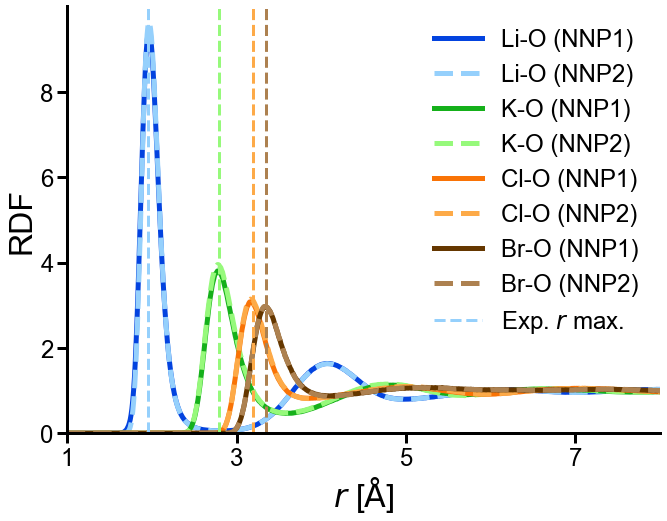

In [74]:

plt.figure(figsize=(10, 8))
plt.plot(r2p5M, RDFarrnorm2p5[:,3,0], label='Li-O (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(r2p5M, RDFarrnorm2p5[:,3,2], label='Li-O (NNP2)', linewidth=5, color=bright_colors[3], linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,3,0], label='K-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,3,2], label='K-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,4,0], label='Cl-O (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,4,2], label='Cl-O (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,4,0], label='Br-O (NNP1)', linewidth=5, color=bright_colors[6])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,4,2], label='Br-O (NNP2)', linewidth=5, color=bright_colors[7], linestyle='--')
plt.axvline(x=1.96, color=bright_colors[3], linestyle='--', label='Exp. $r$ max.', linewidth=3)
plt.axvline(x=2.79, color=bright_colors[5], linestyle='--', linewidth=3)
plt.axvline(x=3.2, color=bright_colors[4], linestyle='--',  linewidth=3)
plt.axvline(x=3.35, color=bright_colors[7], linestyle='--',  linewidth=3)



plt.xlim([1, 8])
plt.ylim([0,10])


# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,10.0, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style()  
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFIonOwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()



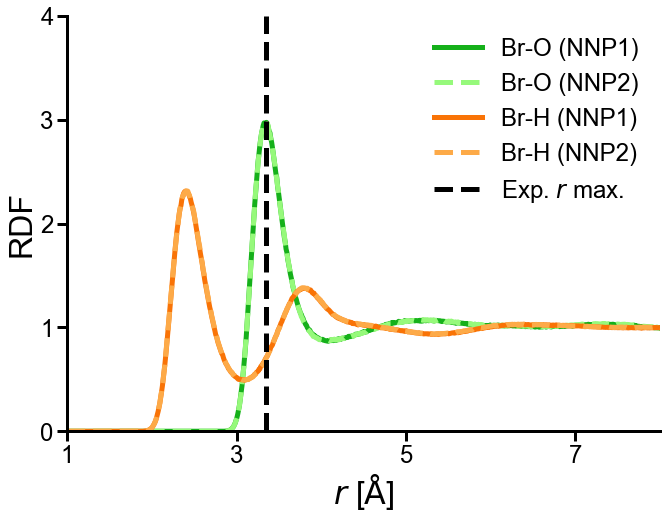

In [75]:

plt.figure(figsize=(10, 8))
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,4,1], label='Br-O (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,4,4], label='Br-O (NNP2)', linewidth=5, color=bright_colors[5], linestyle='--')
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,6,1], label='Br-H (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,6,4], label='Br-H (NNP2)', linewidth=5, color=bright_colors[4], linestyle='--')
plt.axvline(x=3.35, color='black', linestyle='--', label='Exp. $r$ max.', linewidth=5)


plt.xlim([1, 8])
plt.ylim([0, 4])
# Axis ticks
plt.xticks(np.arange(1,8.01, 2))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFClLiBrwatcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


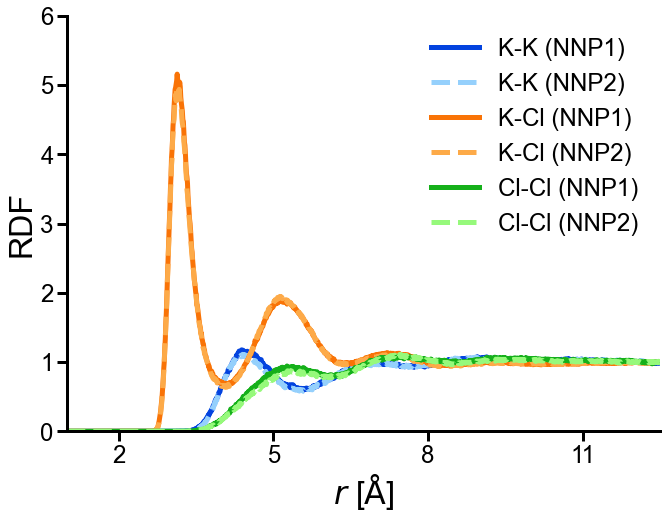

In [76]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,0,1], label='K-K (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,0,2], label='K-K (NNP2)', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,1,1], label='K-Cl (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,1,2], label='K-Cl (NNP2)', linewidth=5, color=bright_colors[4],linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,2,1], label='Cl-Cl (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,2,2], label='Cl-Cl (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 6])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,6.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFKClkc32p5M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

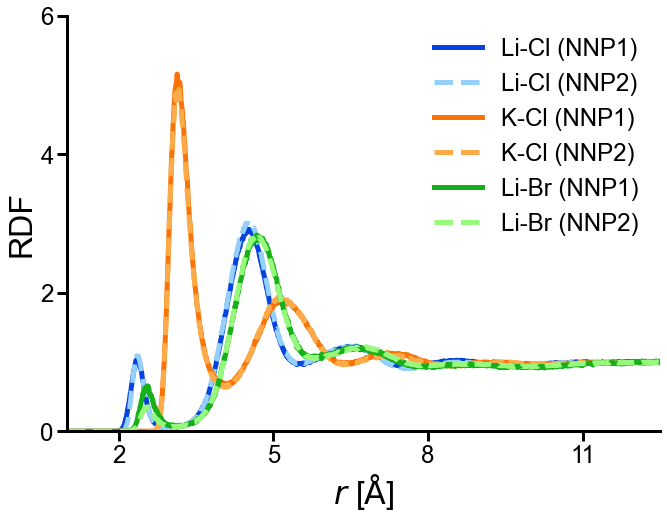

In [77]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(r2p5M, RDFarrnorm2p5[:,1,0], label='Li-Cl (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(r2p5M, RDFarrnorm2p5[:,1,3], label='Li-Cl (NNP2)', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,1,1], label='K-Cl (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,1,2], label='K-Cl (NNP2)', linewidth=5, color=bright_colors[4],linestyle='--')
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,1,0], label='Li-Br (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,1,6], label='Li-Br (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 6])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,6.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFCatAn2p5M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    

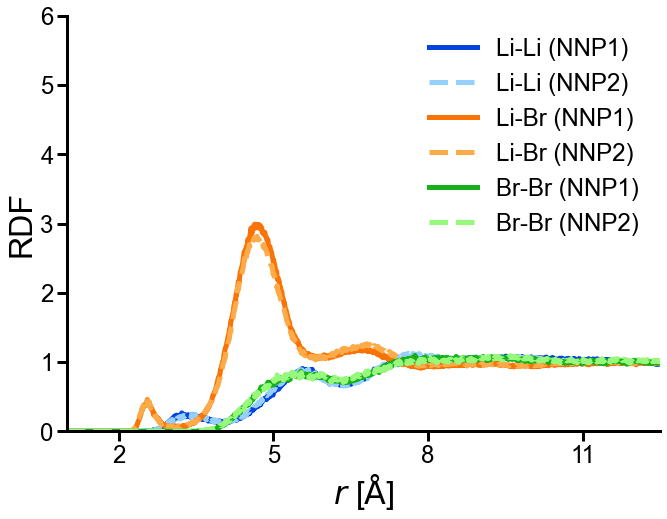

In [78]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,0,1], label='Li-Li (NNP1)', linewidth=5, color=bright_colors[0])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,0,3], label='Li-Li (NNP2)', linewidth=5, color=bright_colors[3],linestyle='--') 
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,1,1], label='Li-Br (NNP1)', linewidth=5, color=bright_colors[1])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,1,3], label='Li-Br (NNP2)', linewidth=5, color=bright_colors[4],linestyle='--')
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,2,1], label='Br-Br (NNP1)', linewidth=5, color=bright_colors[2])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,2,3], label='Br-Br (NNP2)', linewidth=5, color=bright_colors[5],linestyle='--')

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 6])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,6.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()

 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiBrlb32p5M.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    

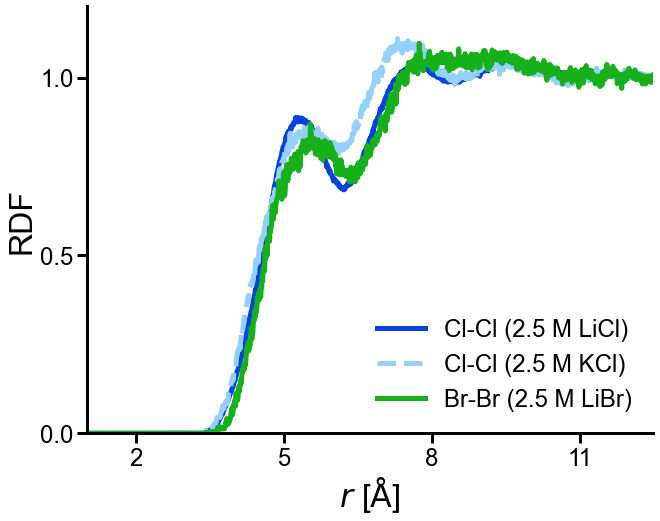

In [79]:
 
    # Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(rKCl2p5M, RDFarrnorm2p5[:,2,4], label='Cl-Cl (2.5 M LiCl)', linewidth=5, color=bright_colors[0])
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,2,3], label='Cl-Cl (2.5 M KCl)', linewidth=5, color=bright_colors[3],linestyle='--')
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,2,1], label='Br-Br (2.5 M LiBr)', linewidth=5, color=bright_colors[2])

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 1.2])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,1.21, .5))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='lower right', fontsize=24, frameon=False)
    
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFClClLiClvsKClvsBrBr.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

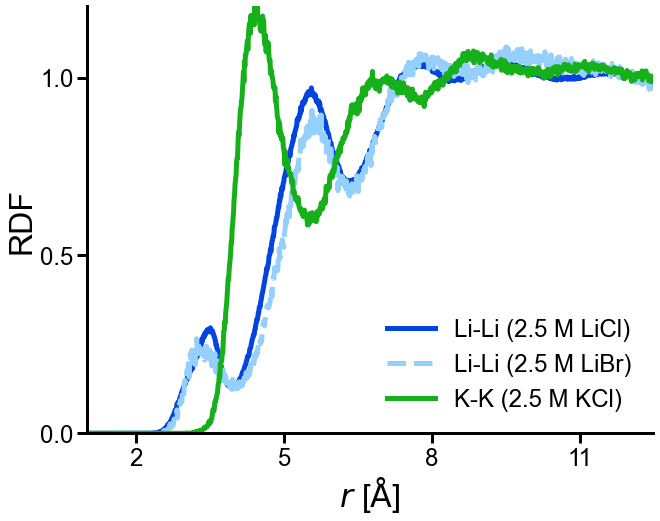

In [80]:
plt.figure(figsize=(10, 8))
 
plt.plot(rKCl2p5M, RDFarrnorm2p5[:,0,4], label='Li-Li (2.5 M LiCl)', linewidth=5, color=bright_colors[0])
plt.plot(rLiBr2p5M, RDFarrnormLiBr2p5[:,0,1], label='Li-Li (2.5 M LiBr)', linewidth=5, color=bright_colors[3],linestyle='--')
plt.plot(rKCl2p5M, RDFarrnormKCl2p5[:,0,3], label='K-K (2.5 M KCl)', linewidth=5, color=bright_colors[2])

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 1.2])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,1.21, .5))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='lower right', fontsize=24, frameon=False)
    
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiLiLiClvsKKClvsLiLiBr.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    
    

Now comparing forces of LiCl recomputed at DFT level with NNP. 

-0.807171


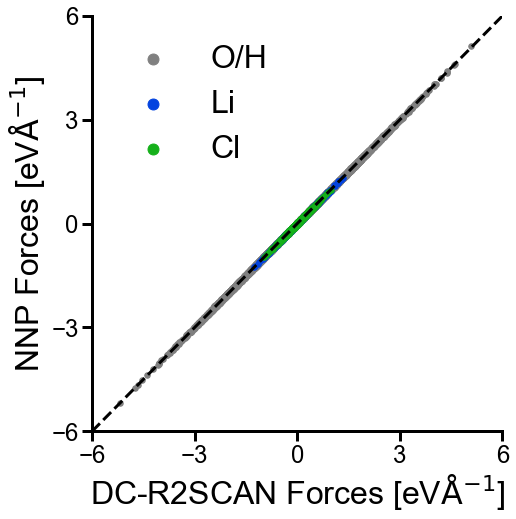

0.009738705293145822
0.009785209676660083
0.00978125300098244
0.008949295862515652
0.00849985209349718


In [81]:
#!/usr/bin/env python                                                                                                               
import numpy as np
from numpy import linalg as LA
import scipy as scipy
import os 
import matplotlib.pyplot as plt


nframes=200
natoms=248

def distance(x0, x1, dimensions): #Given a vector x1 and an array of vectors x0 cell parameter vector dimensions returns vector of distances.                                            
    delta = np.abs(x0 - x1)
    delta = np.where(delta > 0.5 * dimensions, delta - dimensions, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

def readinputxyz(inputlocation): #funtion to read an input file at given location and spit back out an arry of all of the coordinates/forces. assumes two header lines and atomtype specification before xyz coords.
    with open(inputlocation,'r') as waterstrucfile:
        data = np.zeros([nframes, natoms, 3], dtype="float64")
        atoms = [['' for _ in range(natoms)] for _ in range(nframes)]   
        for i in range(0,nframes):
            waterstrucfile.readline()
            waterstrucfile.readline()
            for j in range(0,natoms):
                line = waterstrucfile.readline().split()
                atoms[i][j]=line[0]
                data[i][j] = [float(line[1]), float(line[2]), float(line[3])]   
    return atoms,data

def readinputcp2kforce(inputlocation): #funtion to read an input file at given location and spit back out an arry of all of the coordinates/forces. assumes two header lines and atomtype specification before xyz coords.
    with open(inputlocation,'r') as waterstrucfile:
        data = np.zeros([nframes, natoms, 3], dtype="float64")
        for i in range(0,nframes):
            waterstrucfile.readline()
            waterstrucfile.readline()
            waterstrucfile.readline()
            waterstrucfile.readline()
            waterstrucfile.readline()
            for j in range(0,natoms):
                line = waterstrucfile.readline().split()
                data[i][j] = [float(line[3]), float(line[4]), float(line[5])]   
    return data

def readinputlmps(inputlocation): #funtion to read an input file at given location and spit back out an arry of all of the coordinates/forces. assumes two header lines and atomtype specification before xyz coords.
    with open(inputlocation,'r') as waterstrucfile:
        data = np.zeros([nframes, natoms, 3], dtype="float64")
        for i in range(0,nframes):
            for j in range(0,9):
                waterstrucfile.readline()
            for j in range(0,natoms):
                line = waterstrucfile.readline().split()
                data[i][j]=np.array(line[2:5])
    return data


def readLCs(inputlocation):
    with open(inputlocation,'r') as RMSD:
        line_count = sum(1 for _ in RMSD)
        RMSD.seek(0)
        num_columns = len(RMSD.readline().split())
        RMSD.seek(0)
        data = np.zeros([line_count, num_columns], dtype="float64")
        for i in range(line_count):
            data[i] = [float(item) for item in RMSD.readline().split()]   
    return data

def main():
    CP2Kforces=readinputcp2kforce(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl-DCSR2CAN-reftrajforces-l3.xyz"))
    NequIPforces=readinputlmps(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl-out-frc-l3-2p4M-reftrajcheck.lammpstrj"))
    #forceout = open("~/Desktop/forcecorel.dat", "w")
    #forceOout = open("~/Desktop/forcecorelO.dat", "w")
    #forceHout = open("~/Desktop/forcecorelH.dat", "w")
    #forceNaout = open("~/Desktop/forcecorelNa.dat", "w")
    #forceClout = open("~/Desktop/forcecorelCl.dat", "w")
    #print(CP2Kforces)
    CP2Kxforces=CP2Kforces[:,:,0].flatten()*51.42194722410109
    CP2Kyforces=CP2Kforces[:,:,1].flatten()*51.42194722410109
    CP2Kzforces=CP2Kforces[:,:,2].flatten()*51.42194722410109
    CP2KNaforces=np.array([])
    for i in range(0,4):
        CP2KNaforces=np.append(CP2KNaforces,CP2Kxforces[natoms-8+i::natoms])
        CP2KNaforces=np.append(CP2KNaforces,CP2Kyforces[natoms-8+i::natoms])
        CP2KNaforces=np.append(CP2KNaforces,CP2Kzforces[natoms-8+i::natoms])
    CP2KClforces=np.array([])
    for i in range(0,4):
        CP2KClforces=np.append(CP2KClforces,CP2Kxforces[natoms-4+i::natoms])
        CP2KClforces=np.append(CP2KClforces,CP2Kyforces[natoms-4+i::natoms])
        CP2KClforces=np.append(CP2KClforces,CP2Kzforces[natoms-4+i::natoms])
    NequIPxforces=NequIPforces[:,:,0].flatten()
    NequIPyforces=NequIPforces[:,:,1].flatten()
    NequIPzforces=NequIPforces[:,:,2].flatten()
    print(NequIPxforces[0])
    NequIPNaforces=np.array([])
    for i in range(0,4):
        NequIPNaforces=np.append(NequIPNaforces,NequIPxforces[natoms-8+i::natoms])
        NequIPNaforces=np.append(NequIPNaforces,NequIPyforces[natoms-8+i::natoms])
        NequIPNaforces=np.append(NequIPNaforces,NequIPzforces[natoms-8+i::natoms])
    NequIPClforces=np.array([])
    for i in range(0,4):
        NequIPClforces=np.append(NequIPClforces,NequIPxforces[natoms-4+i::natoms])
        NequIPClforces=np.append(NequIPClforces,NequIPyforces[natoms-4+i::natoms])
        NequIPClforces=np.append(NequIPClforces,NequIPzforces[natoms-4+i::natoms])
    
    
    # Increase the figure size for better clarity
    plt.figure(figsize=(8, 8))
    

    # Scatter plots
    plt.scatter(CP2Kxforces, NequIPxforces, s=30, label='O/H' ,color='gray')
    plt.scatter(CP2KNaforces, NequIPNaforces, s=30, label='Li',color=bright_colors[0])
    plt.scatter(CP2KClforces, NequIPClforces, s=30, label='Cl',color=bright_colors[2])
    
    # Set the x and y limits
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])

    # Add a y=x line
    plt.plot([-6, 6], [-6, 6], color='black', linestyle='--', linewidth=3)

    # Add labels, title and legend
    plt.xlabel('DC-R2SCAN Forces [eV$\mathrm{\AA^{-1}}$]', fontsize=32)
    plt.ylabel('NNP Forces [eV$\mathrm{\AA^{-1}}$]', fontsize=32)
    #plt.title('Comparison of Forces', fontsize=32)
    plt.legend(loc='upper left', fontsize=24)

    # Use a faint grid for better legibility
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Axis ticks
    plt.xticks(np.arange(-6,6.01, 3))
    plt.yticks(np.arange(-6,6.01, 3))

    plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
    # Display the plot
    set_plot_style()  
    plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/Forcecorrel.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
    plt.show()
    
    
    SumSq=0.0
    for i in range(0,len(NequIPxforces)):
        SumSq+=(CP2Kxforces[i]-NequIPxforces[i])**2.0
    print((SumSq/len(NequIPxforces))**0.5)
    SumSq=0.0
    for i in range(0,len(NequIPyforces)):
        SumSq+=(CP2Kyforces[i]-NequIPyforces[i])**2.0
    print((SumSq/len(NequIPyforces))**0.5)
    SumSq=0.0
    for i in range(0,len(NequIPzforces)):
        SumSq+=(CP2Kzforces[i]-NequIPzforces[i])**2.0
    print((SumSq/len(NequIPzforces))**0.5)
    SumSq=0.0
    for i in range(0,len(NequIPNaforces)):
        SumSq+=(CP2KNaforces[i]-NequIPNaforces[i])**2.0   
    print((SumSq/len(NequIPNaforces))**0.5)
    SumSq=0.0
    for i in range(0,len(NequIPClforces)):
        SumSq+=(CP2KClforces[i]-NequIPClforces[i])**2.0
    print((SumSq/len(NequIPClforces))**0.5)
    
    #for i in range(0,nframes*4,10):
    #    forceNaout.write(str(CP2KNaforces[i])+" "+str(NequIPNaforces[i])+"\n")
    #    forceClout.write(str(CP2KClforces[i])+" "+str(NequIPClforces[i])+"\n")
    #for i in range(0,nframes*natoms,100):
    #    forceout.write(str(CP2Kxforces[i])+" "+str(NequIPxforces[i])+"\n")
    #for i in range(0,nframes*natoms):
    #    if(abs(CP2Kxforces[i])>3):forceout.write(str(CP2Kxforces[i])+" "+str(NequIPxforces[i])+"\n")
    
main()





Now computing diffusivities, use a simple correction for finite size effects need to improve. Also dropped one of the 2.5 M runs as there was a proton hop on to a Li which effected its diffusivities. 

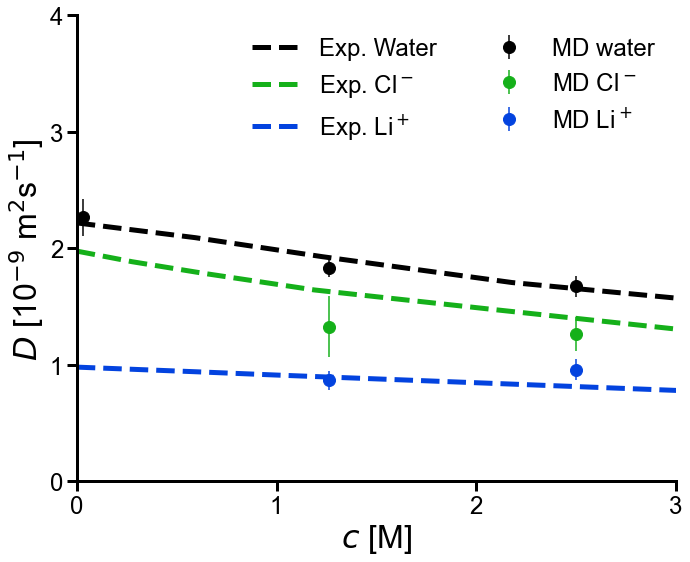

In [82]:
#!/usr/bin/env python                                                                                                               
import numpy as np
from numpy import linalg as LA
import scipy as scipy
import os 
import matplotlib.pyplot as plt

convconst=1/6*10**-20*10**12*100**2*10**5
visc = 0.888/1000
kBT=4.14195*10**-21

def readRMSDs(inputlocation):
    with open(inputlocation,'r') as RMSD:
        line_count = sum(1 for _ in RMSD)
        RMSD.seek(0)
        num_columns = len(RMSD.readline().split())
        RMSD.seek(0)
        data = np.zeros([line_count, num_columns], dtype="float64")
        for i in range(line_count):
            data[i] = [float(item) for item in RMSD.readline().split()]   
    return data


def calculate_Dwat(MSDdat, boxL):
    t = [row[0] * 20/2000 for row in MSDdat]
    MSD = [row[1] ** 2.0 for row in MSDdat]
    corr = kBT * 2.837297 / (6 * np.pi * visc * boxL * 10**-10) * 100**2 * 10**5
    n = len(t)
    indices = np.linspace(0, n, 5, endpoint=True, dtype=int)
    Dwat = np.zeros(4)
    for i in range(4):
        t_subset = t[indices[i]:indices[i + 1]]
        MSD_subset = MSD[indices[i]:indices[i + 1]]
        coefficients = np.polyfit(t_subset, MSD_subset, deg=1)
        Dwat[i] = coefficients[0] * convconst + corr
    return Dwat, (np.max(Dwat) - np.min(Dwat)) / 2

def calculate_Dwatfull(MSDdat, boxL):
    t = [row[0] * 20/2000 for row in MSDdat]
    MSD = [row[1] ** 2.0 for row in MSDdat]
    corr = kBT * 2.837297 / (6 * np.pi * visc * boxL * 10**-10) * 100**2 * 10**5
    coefficients = np.polyfit(t, MSD, deg=1)
    Dwat = coefficients[0] * convconst + corr
    return Dwat



convconst = 1/6*10**-20*10**12*100**2*10**5
visc = 0.888/1000
kBT = 4.14195*10**-21
#exp data are from: DOI: 10.1039/f19878301779
WatD=np.array([[0, 559/756*3.0], [15/505*20.0, 527/756*3.0], [31/505*20.0, 486/756*3.0], [55/505*20.0, 430/756*3.0], [143/505*20.0, 287/756*3.0]])
ClD=np.array([[0, 498/756*3.0], [7/505*20.0, 475/756*3.0],[16/505*20.0, 450/756*3.0], [30/505*20.0, 414/756*3.0], [53/505*20.0, 371/756*3.0], [77/505*20.0, 327/756*3.0], [100/505*20.0, 290/756*3.0]])
LiD=np.array([[0, 247/756*3.0], [15/505*20.0, 237/756*3.0], [25/505*20.0,230/756*3.0],[142/505*20.0,153/756*3.0], [347/505*20.0, 52/756*3.0]])


# Read and process data for OMSDwater
OMSDwater = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/ORMSD-bigbox.dat")) 
boxL = 21.6
Dwat, errorDwat = calculate_Dwat(OMSDwater, boxL)

# Read and process data for OMSDwaterl3b2p4Mr2
OMSDwaterl3b2p4Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/ORMSD-l3b-2p4M-run2.dat"))
boxL = 25.26 
Dwat2p4, errorDwat2p4 = calculate_Dwat(OMSDwaterl3b2p4Mr2, boxL)

# Read and process data for OMSDwaterl3b2p4Mr2
OMSDwaterl3b1p2Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/ORMSD-l3b-1p2M-run2.dat"))
boxL =  25.05 
Dwat1p2, errorDwat1p2 = calculate_Dwat(OMSDwaterl3b1p2Mr2, boxL)


ClMSDwaterl31p2Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3-1p2M-run1.dat"))
ClMSDwaterl3b1p2Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3b-1p2M-run1.dat"))
ClMSDwaterl31p2Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3-1p2M-run2.dat"))
ClMSDwaterl3b1p2Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3b-1p2M-run2.dat"))
boxL = 25.05

DCls1p2M = np.array([calculate_Dwatfull(ClMSDwaterl31p2Mr1, boxL),calculate_Dwatfull(ClMSDwaterl3b1p2Mr1, boxL),calculate_Dwatfull(ClMSDwaterl31p2Mr2, boxL),calculate_Dwatfull(ClMSDwaterl3b1p2Mr2, boxL)])  
Cl1p2D=np.mean(DCls1p2M)
Cl1p2Derr=(np.max(DCls1p2M) - np.min(DCls1p2M)) / 2


ClMSDwaterl32p4Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3-2p4M-run2.dat"))
ClMSDwaterl3b2p4Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3b-2p4M-run1.dat"))
ClMSDwaterl3b2p4Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Cl-l3b-2p4M-run2.dat"))
boxL = 25.26

DCls2p4M = np.array([calculate_Dwatfull(ClMSDwaterl32p4Mr2, boxL),calculate_Dwatfull(ClMSDwaterl3b2p4Mr1, boxL),calculate_Dwatfull(ClMSDwaterl3b2p4Mr2, boxL)])  
Cl2p4D=np.mean(DCls2p4M)
Cl2p4Derr=(np.max(DCls2p4M) - np.min(DCls2p4M)) / 2

LiMSDwaterl31p2Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3-1p2M-run1.dat"))
LiMSDwaterl3b1p2Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3b-1p2M-run1.dat"))
LiMSDwaterl31p2Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3-1p2M-run2.dat"))
LiMSDwaterl3b1p2Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3b-1p2M-run2.dat"))
boxL = 25.05

DLis1p2M = np.array([calculate_Dwatfull(LiMSDwaterl31p2Mr1, boxL),calculate_Dwatfull(LiMSDwaterl3b1p2Mr1, boxL),calculate_Dwatfull(LiMSDwaterl31p2Mr2, boxL),calculate_Dwatfull(LiMSDwaterl3b1p2Mr2, boxL)])
Li1p2D=np.mean(DLis1p2M)
Li1p2Derr=(np.max(DLis1p2M) - np.min(DLis1p2M)) / 2

LiMSDwaterl32p4Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3-2p4M-run2.dat"))
LiMSDwaterl3b2p4Mr1 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3b-2p4M-run1.dat"))
LiMSDwaterl3b2p4Mr2 = readRMSDs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RMSD-Li-l3b-2p4M-run2.dat"))
boxL = 25.26

DLis2p4M = np.array([calculate_Dwatfull(LiMSDwaterl32p4Mr2, boxL),calculate_Dwatfull(LiMSDwaterl3b2p4Mr1, boxL),calculate_Dwatfull(LiMSDwaterl3b2p4Mr2, boxL)])
Li2p4D=np.mean(DLis2p4M)
Li2p4Derr=(np.max(DLis2p4M) - np.min(DLis2p4M)) / 2


plt.figure(figsize=(10, 8))
plt.errorbar(0.03,np.mean(Dwat), yerr=errorDwat,  fmt='o', color='black', label='MD water',markersize=12)
plt.errorbar(1.26,np.mean(Dwat1p2), yerr=errorDwat1p2,  fmt='o', color='black',markersize=12)
plt.errorbar(2.5,np.mean(Dwat2p4), yerr=errorDwat2p4,  fmt='o', color='black',markersize=12)
plt.errorbar(1.26,Cl1p2D, yerr=Cl1p2Derr,  fmt='o', color=bright_colors[2],markersize=12,label='MD Cl$^-$')
plt.errorbar(2.5,Cl2p4D, yerr=Cl2p4Derr,  fmt='o', color=bright_colors[2],markersize=12)
plt.errorbar(2.5,Li2p4D, yerr=Li2p4Derr,  fmt='o', color=bright_colors[0],markersize=12,label='MD Li$^+$')
plt.errorbar(1.26,Li1p2D, yerr=Li1p2Derr,  fmt='o', color=bright_colors[0],markersize=12)
plt.plot( WatD[:,0],  WatD[:,1], label='Exp. Water',linewidth=5, color='black',linestyle='--')
plt.plot(ClD[:,0], ClD[:,1], label='Exp. Cl$^-$',linewidth=5, color=bright_colors[2],linestyle='--')
plt.plot(LiD[:,0], LiD[:,1], label='Exp. Li$^+$',linewidth=5, color=bright_colors[0],linestyle='--')
set_plot_style()
#plt.plot(t, D,  linewidth=5, color=bright_colors[0])
plt.xlim([0,3])
plt.ylim([0, 3])
# Axis ticks
plt.xticks(np.arange(0,3.01, 1))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$c$ [M]', fontsize=32)
plt.ylabel('$D$ [10$^{-9}$ m$^2$s$^{-1}$] ', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False,ncol=2)
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/Diffs.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    

Now plotting KB integrals compared with experiment. 

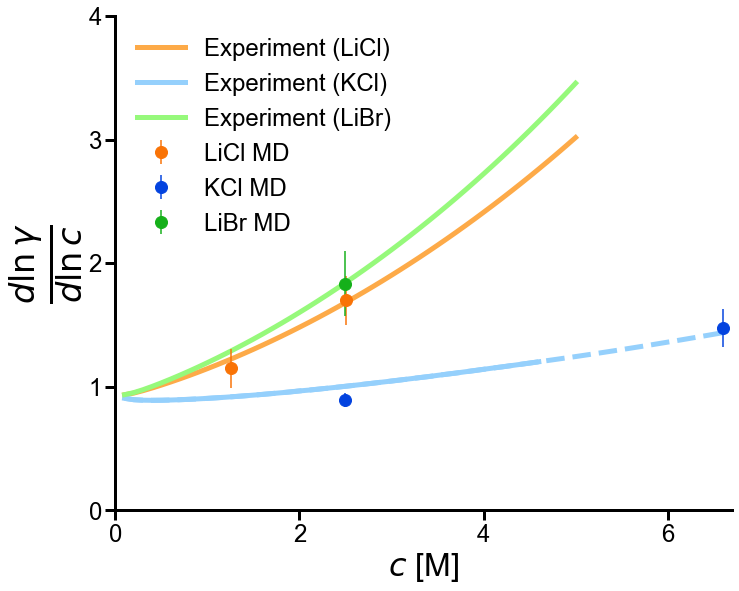

In [83]:
dlgambdlcexpLiCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/dlgambdlcexpLiCl.dat"))
dlgambdlcexpKCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/dlgambdlcexpKCl.dat"))
dlgambdlcexpLiBr=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/dlgambdlcexpLiBr.dat"))

c=dlgambdlcexpLiCl[:,0]
dgambdlcexlLiCl = dlgambdlcexpLiCl[:,1]
cKCl=dlgambdlcexpKCl[:,0]
dgambdlcexlKCl = dlgambdlcexpKCl[:,1]
cLiBr=dlgambdlcexpLiBr[:,0]
dgambdlcexlLiBr = dlgambdlcexpLiBr[:,1]
    
#Cutting KCl off at its experimental solubility of 4.6
cutoff_index = 46
plt.figure(figsize=(11, 9))
plt.plot( c, dgambdlcexlLiCl, label='Experiment (LiCl)', linewidth=5, color=bright_colors[4])
plt.plot( cKCl, dgambdlcexlKCl,linewidth=5, color=bright_colors[3],linestyle='--')
plt.plot(cKCl[:cutoff_index], dgambdlcexlKCl[:cutoff_index],  label='Experiment (KCl)', linewidth=5, color=bright_colors[3])
plt.plot( cLiBr, dgambdlcexlLiBr, label='Experiment (LiBr)', linewidth=5, color=bright_colors[5])
plt.errorbar(1.26, TheoryKBnorm1p2MLiCl, yerr=TheoryKBnorm1p2MerrLiCl,  fmt='o', color=bright_colors[1], label='LiCl MD',markersize=12)
plt.errorbar(2.501, TheoryKBnorm2p5MLiCl, yerr=TheoryKBnorm2p5MerrLiCl, fmt='o', color=bright_colors[1], markersize=12)
plt.errorbar(2.5, TheoryKBnorm2p5MKCl, yerr=TheoryKBnorm2p5MerrKCl, fmt='o', color=bright_colors[0],label='KCl MD',markersize=12)
plt.errorbar(6.6, TheoryKBnorm6p6MKCl, yerr=TheoryKBnorm6p6MerrKCl, fmt='o', color=bright_colors[0],markersize=12)
plt.errorbar(2.5, TheoryKBnorm2p5MLiBr, yerr=TheoryKBnorm2p5MerrLiBr, fmt='o', color=bright_colors[2],label='LiBr MD',markersize=12)

#plt.errorbar(1.26, 1.12, yerr=0.02,  fmt='o', color=bright_colors[2],markersize=12)
#plt.errorbar(2.4, 1.53, yerr=0.01,  fmt='o', color=bright_colors[2], label='CG MD',markersize=12)
    
plt.xlim([0,6.7])
plt.ylim([0, 4])

    # Axis ticks
plt.xticks(np.arange(0,6.7, 2))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel(r'$c$ [M]', fontsize=32)
plt.ylabel(r'$\frac{d\ln\gamma}{d\lnc}$', fontsize=48)
plt.legend(loc='upper left', fontsize=24, frameon=False)
    
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/KBactcomp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()
    

epoch                       1.000000
 wall                      32.305000
 LR                         0.010000
training_loss_f             0.183050
training_loss_e             0.212580
training_loss              18.517000
training_O_f_rmse           0.518000
training_H_f_rmse           0.368000
training_Li_f_rmse          0.230000
training_Cl_f_rmse          0.170000
training_psavg_f_rmse       0.321000
training_e/N_rmse           0.375000
validation_loss_f           0.034773
validation_loss_e           0.000127
validation_loss             3.477500
validation_O_f_rmse         0.184000
validation_H_f_rmse         0.138000
validation_Li_f_rmse        0.143000
validation_Cl_f_rmse        0.141000
validation_psavg_f_rmse     0.152000
validation_e/N_rmse         0.009100
Name: 0, dtype: float64

 
0          1
1          2
2          3
3          4
4          5
        ... 
1144    1145
1145    1146
1146    1147
1147    1148
1148    1149
Name: epoch, Length: 1149, dtype: int64
0       18.51

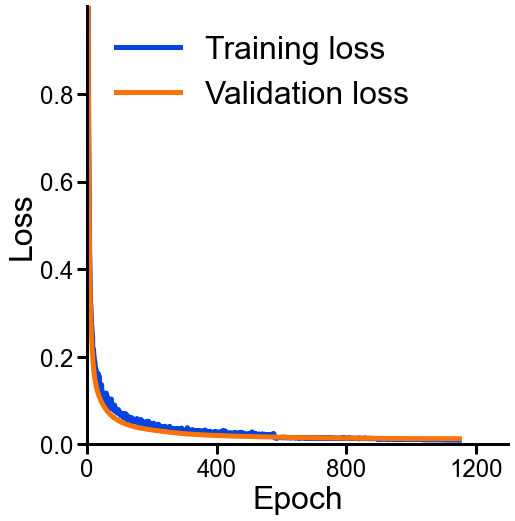

In [84]:


l3LC=pd.read_csv(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/metrics_epoch-l3.csv"))


print(l3LC.iloc[0, :])
print("\n ")
epoch=l3LC.iloc[:, 0]
trainl=l3LC.iloc[:, 5]
vall=l3LC.iloc[:, 14]
print(epoch)
print(trainl)

# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))
    

 # Scatter plots
plt.plot(epoch, trainl, label='Training loss', color=bright_colors[0], linewidth=5,)
plt.plot(epoch, vall, label='Validation loss', color=bright_colors[1], linewidth=5,)
# Set the x and y limits
plt.xlim([0,1300])
plt.ylim([0, 1])


# Add labels, title and legend
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
#plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

# Use a faint grid for better legibility
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# Axis ticks
plt.xticks(np.arange(0,1300, 400))
plt.yticks(np.arange(0, 1,.2))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
 # Display the plot
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LCl3.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


epoch                       1.000000
 wall                      28.991000
 LR                         0.010000
training_loss_f             0.153740
training_loss_e             0.229770
training_loss              15.604000
training_O_f_rmse           0.477000
training_H_f_rmse           0.342000
training_K_f_rmse           0.164000
training_Cl_f_rmse          0.168000
training_psavg_f_rmse       0.288000
training_e/N_rmse           0.386000
validation_loss_f           0.033714
validation_loss_e           0.000014
validation_loss             3.371400
validation_O_f_rmse         0.181000
validation_H_f_rmse         0.133000
validation_K_f_rmse         0.134000
validation_Cl_f_rmse        0.138000
validation_psavg_f_rmse     0.147000
validation_e/N_rmse         0.002990
Name: 0, dtype: float64

 
0          1
1          2
2          3
3          4
4          5
        ... 
1193    1194
1194    1195
1195    1196
1196    1197
1197    1198
Name: epoch, Length: 1198, dtype: int64
0       15.60

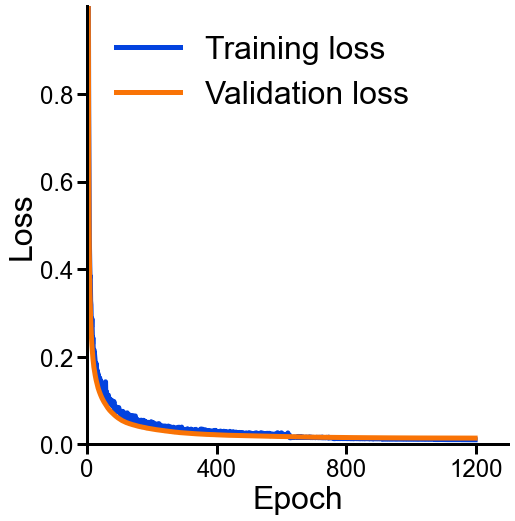

In [85]:


l3LC=pd.read_csv(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/metrics_epoch-kc3.csv"))


print(l3LC.iloc[0, :])
print("\n ")
epoch=l3LC.iloc[:, 0]
trainl=l3LC.iloc[:, 5]
vall=l3LC.iloc[:, 14]
print(epoch)
print(trainl)

# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))
    

 # Scatter plots
plt.plot(epoch, trainl, label='Training loss', color=bright_colors[0], linewidth=5,)
plt.plot(epoch, vall, label='Validation loss', color=bright_colors[1], linewidth=5,)
# Set the x and y limits
plt.xlim([0,1300])
plt.ylim([0, 1])


# Add labels, title and legend
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
#plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

# Use a faint grid for better legibility
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# Axis ticks
plt.xticks(np.arange(0,1300, 400))
plt.yticks(np.arange(0, 1,.2))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LCkc3.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


epoch                       1.000000
 wall                      25.886000
 LR                         0.010000
training_loss_f             0.220520
training_loss_e             0.229030
training_loss              22.281000
training_O_f_rmse           0.560000
training_H_f_rmse           0.395000
training_Li_f_rmse          0.248000
training_Br_f_rmse          0.175000
training_psavg_f_rmse       0.344000
training_e/N_rmse           0.382000
validation_loss_f           0.041048
validation_loss_e           0.002624
validation_loss             4.107400
validation_O_f_rmse         0.204000
validation_H_f_rmse         0.155000
validation_Li_f_rmse        0.158000
validation_Br_f_rmse        0.134000
validation_psavg_f_rmse     0.163000
validation_e/N_rmse         0.040300
Name: 0, dtype: float64

 
0        1
1        2
2        3
3        4
4        5
      ... 
827    828
828    829
829    830
830    831
831    832
Name: epoch, Length: 832, dtype: int64
0      22.281000
1       3.081600
2 

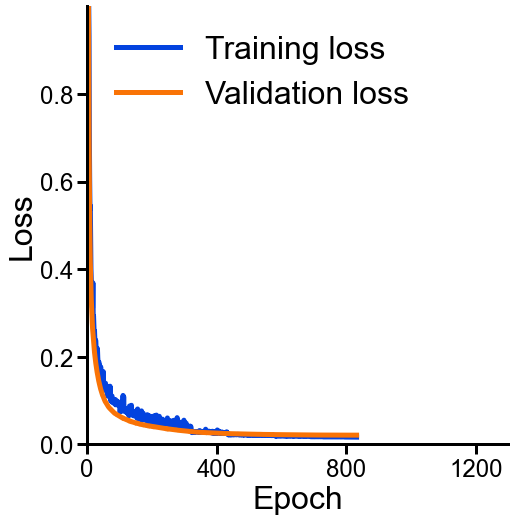

In [86]:


lb3LC=pd.read_csv(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/metrics_epoch-lb3.csv"))


print(lb3LC.iloc[0, :])
print("\n ")
epoch=lb3LC.iloc[:, 0]
trainl=lb3LC.iloc[:, 5]
vall=lb3LC.iloc[:, 14]
print(epoch)
print(trainl)

# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))
    

 # Scatter plots
plt.plot(epoch, trainl, label='Training loss', color=bright_colors[0], linewidth=5,)
plt.plot(epoch, vall, label='Validation loss', color=bright_colors[1], linewidth=5,)
# Set the x and y limits
plt.xlim([0,1300])
plt.ylim([0, 1])


# Add labels, title and legend
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
#plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

# Use a faint grid for better legibility
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# Axis ticks
plt.xticks(np.arange(0,1300, 400))
plt.yticks(np.arange(0, 1,.2))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
 # Display the plot
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LClb3.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


epoch                        1.000000
 wall                      204.535000
 LR                          0.010000
training_loss_f              0.984430
training_loss_e              0.018102
training_loss               98.462000
training_Li_f_rmse           0.350000
training_Cl_f_rmse           0.249000
training_psavg_f_rmse        0.299000
training_e/N_rmse            0.041200
validation_loss_f            0.981510
validation_loss_e            0.015673
validation_loss             98.167000
validation_Li_f_rmse         0.349000
validation_Cl_f_rmse         0.249000
validation_psavg_f_rmse      0.299000
validation_e/N_rmse          0.038300
Name: 0, dtype: float64

 
0      1
1      2
2      3
3      4
4      5
      ..
68    69
69    70
70    71
71    72
72    73
Name: epoch, Length: 73, dtype: int64
0     98.167
1     98.157
2     98.153
3     98.153
4     98.135
       ...  
68    98.106
69    98.106
70    98.106
71    98.106
72    98.106
Name: validation_loss, Length: 73, dtype: float

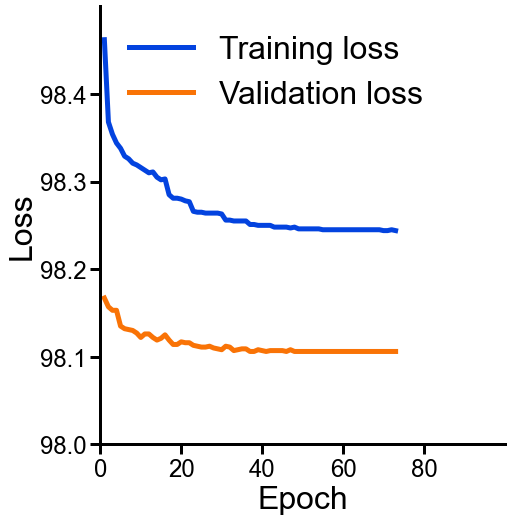

In [87]:
l3LC=pd.read_csv(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/metrics_epoch-l3-cg15.csv"))


print(l3LC.iloc[0, :])
print("\n ")
epoch=l3LC.iloc[:, 0]
trainl=l3LC.iloc[:, 5]
vall=l3LC.iloc[:, 12]
print(epoch)
print(vall)

# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))
    
 # Scatter plots
plt.plot(epoch, trainl, label='Training loss', color=bright_colors[0], linewidth=5,)
plt.plot(epoch, vall, label='Validation loss', color=bright_colors[1], linewidth=5,)
# Set the x and y limits
plt.xlim([0, 100])
plt.ylim([98,98.5])
#plt.ylim([0, .1])

# Add labels, title and legend
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
#plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

# Use a faint grid for better legibility
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# Axis ticks
plt.xticks(np.arange(0, 100,20))
plt.yticks(np.arange(98,98.5, .1))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LCl3-cg15.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


epoch                       1.000000
 wall                      69.491000
 LR                         0.010000
training_loss_f             0.869210
training_loss_e             0.386250
training_loss              86.921000
training_K_f_rmse           0.230000
training_Cl_f_rmse          0.233000
training_psavg_f_rmse       0.231000
training_e/N_rmse           0.154000
validation_loss_f           0.852820
validation_loss_e           0.018687
validation_loss            85.282000
validation_K_f_rmse         0.227000
validation_Cl_f_rmse        0.231000
validation_psavg_f_rmse     0.229000
validation_e/N_rmse         0.033900
Name: 0, dtype: float64

 
0      1
1      2
2      3
3      4
4      5
      ..
88    89
89    90
90    91
91    92
92    93
Name: epoch, Length: 93, dtype: int64
0     85.282
1     85.060
2     85.012
3     84.995
4     84.944
       ...  
88    84.744
89    84.744
90    84.744
91    84.744
92    84.744
Name: validation_loss, Length: 93, dtype: float64


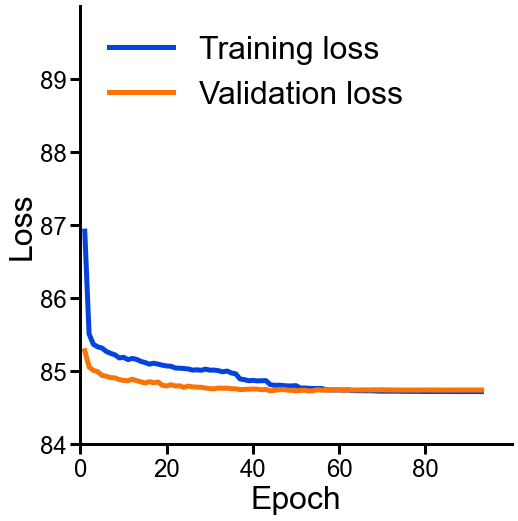

In [88]:
l3LC=pd.read_csv(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/metrics_epoch-kc3-6p6M-cg1.csv"))


print(l3LC.iloc[0, :])
print("\n ")
epoch=l3LC.iloc[:, 0]
trainl=l3LC.iloc[:, 5]
vall=l3LC.iloc[:, 12]
print(epoch)
print(vall)

# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))
    
 # Scatter plots
plt.plot(epoch, trainl, label='Training loss', color=bright_colors[0], linewidth=5,)
plt.plot(epoch, vall, label='Validation loss', color=bright_colors[1], linewidth=5,)
# Set the x and y limits
plt.xlim([0, 100])
plt.ylim([84,90])
#plt.ylim([0, .1])

# Add labels, title and legend
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
#plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

# Use a faint grid for better legibility
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# Axis ticks
plt.xticks(np.arange(0, 100,20))
plt.yticks(np.arange(84,90, 1))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
 # Display the plot
set_plot_style()   
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LCkc3-6p6M-cg1.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


[0.5818218493786477, -0.96151687970616, 0.35848604819493174, 0.28595539163533723, 0.28903196673775516, -0.12388832634966554, -0.11149975082443511, -0.41304473419970306, 0.7510010841848846, 1.2045616848219292, 0.14592417339360958, 0.09952615041330318, 0.03854332054182497, -0.3094367096157507, -0.35866139703496597, 0.28376327402517376, 0.05610854349410566, 0.22994506406042958, 0.3631644169533805, 0.43806305418264496, -0.4710445769127111, 0.03625607232929696, 0.26356884691132476, -0.18888618186040157, 0.06663358765193468, 0.11313034077091136, 0.35560024851671523, 0.11854147227730351, 0.2903895061444714, 0.1426943608884638, 0.4459172424016542, 0.20222400653138892, 0.1449538412494908, -0.519176033733942, 0.1131169710646331, -0.4536824706519657, 0.17157909708318586, -0.19839564256055459, -0.08544784970228878, -0.06813305163298945, 0.057027453691000346, -0.4714405259063367, 0.2946657552756277, -0.4295239256266107, 0.13976382411616228, -0.45948132364042754, -0.23932596989252233, -0.14677160708

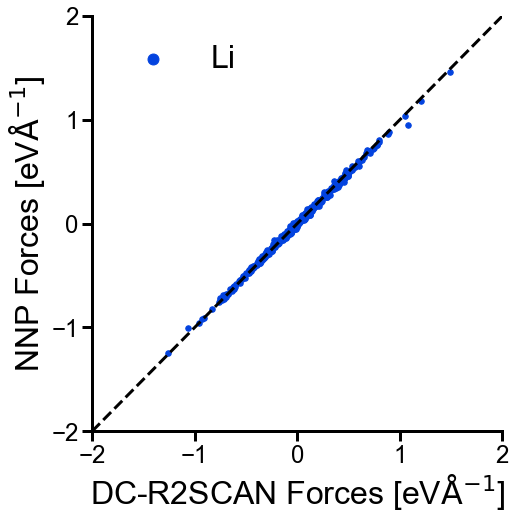

In [89]:
nframes=74
atoms,coords = readinputxyz(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl-Lipairs.xyz"))
CP2Kforce=readinputcp2kforce(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl-DCSR2CAN-reftrajforces-Lipair-DZVP.xyz"))
NNPforces=readinputlmps(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl-l3-reftrajforces-Lipair.xyz"))                                           
Lbox=np.array([13.8674,13.8674,13.8674])
Lipairs = np.zeros([nframes,2], dtype="float64")
CP2Kforcelist=[]
NNPforcelist=[]
    
for i in range(nframes):
    Liind=[]
        
    for j in range(natoms):
        if atoms[i][j] == 'Li':
            Liind.append(j)
    for k in range(len(Liind)):
        for l in range(k + 1, len(Liind)):  
            d=distance(coords[i][Liind[k]],coords[i][Liind[l]],Lbox)
            if d < 4.1:
                Lipairs[i]=[Liind[k],Liind[l]]
                for m in range(3):
                    CP2Kforcelist.append(CP2Kforce[i][Liind[k]][m]*51.42194722410109)
                    CP2Kforcelist.append(CP2Kforce[i][Liind[l]][m]*51.42194722410109)
                    NNPforcelist.append(NNPforces[i][Liind[k]][m])
                    NNPforcelist.append(NNPforces[i][Liind[l]][m])

print(CP2Kforcelist)
# Increase the figure size for better clarity
plt.figure(figsize=(8, 8))

    # Scatter plots

plt.scatter(CP2Kforcelist, NNPforcelist, s=30, label='Li',color=bright_colors[0])
    
    # Set the x and y limits
plt.xlim([-2, 2])
plt.ylim([-2, 2])

    # Add a y=x line
plt.plot([-2, 2], [-2, 2], color='black', linestyle='--', linewidth=3)

    # Add labels, title and legend
plt.xlabel('DC-R2SCAN Forces [eV$\mathrm{\AA^{-1}}$]', fontsize=32)
plt.ylabel('NNP Forces [eV$\mathrm{\AA^{-1}}$]', fontsize=32)
    #plt.title('Comparison of Forces', fontsize=32)
plt.legend(loc='upper left', fontsize=24)

    # Use a faint grid for better legibility
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Axis ticks
plt.xticks(np.arange(-2,2.01, 1))
plt.yticks(np.arange(-2,2.01, 1))

plt.legend(loc='upper left', fontsize=32, frameon=False, markerscale=2)
set_plot_style()   
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/ForcecorrelLidimer.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()

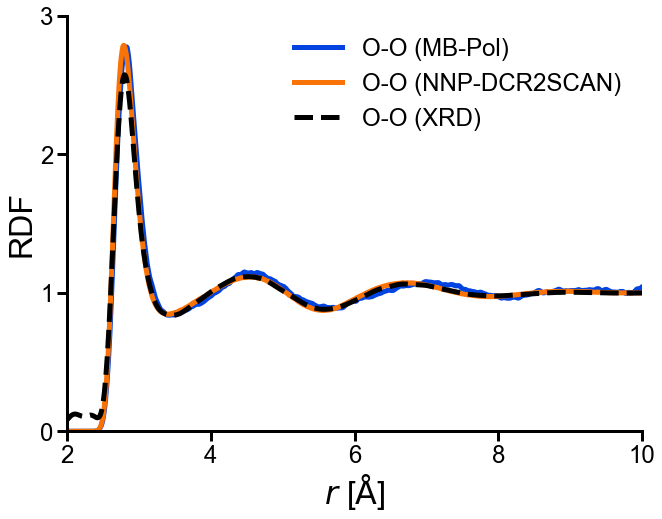

In [90]:
RDFOO=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/gofrOO-l3-water-bigbox.dat"))
RDFOOXRD=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/XRDRDF-OO.dat"))
RDFOOMBPOL=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/gofrOO-MBPol.dat"))
    
x = [row[0] for row in RDFOO]
y1 = [row[1] for row in RDFOO]
xXRD = [row[0] for row in RDFOOXRD]
y1XRD = [row[1] for row in RDFOOXRD]
xMBPol = [row[0] for row in RDFOOMBPOL]
y1MBPol = [row[1] for row in RDFOOMBPOL]
    
plt.figure(figsize=(10, 8))
plt.plot(xMBPol, y1MBPol, label='O-O (MB-Pol)', linewidth=5, color=bright_colors[0])
plt.plot(x, y1, label='O-O (NNP-DCR2SCAN)', linewidth=5, color=bright_colors[1])
plt.plot(xXRD, y1XRD, label='O-O (XRD)', linestyle='--',linewidth=5,color='Black')
plt.xlim([2, 10])
plt.ylim([0, 3])
# Axis ticks
plt.xticks(np.arange(2,10.01, 2))
plt.yticks(np.arange(0,3.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style()  
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFOO.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()

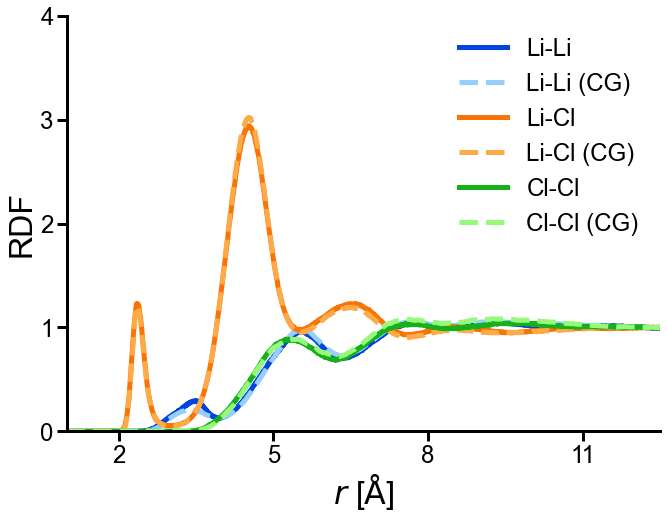

In [91]:
RDFLiCll32p4Mcg15=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RDF-LiCl-cg15-2p4M-bigbox.dat"))

norm_factors = next((row[1:] for row in RDFLiCll32p4Mcg15 if row[0] == 12.5), None)
normalized_data = [[row[0]] + [row[j] / norm_factors[j-1] for j in range(1, 4)] for row in RDFLiCll32p4Mcg15]
rcg15 = [row[0] for row in normalized_data]
y1cg15 = [row[1] for row in normalized_data]
y2cg15 = [row[2] for row in normalized_data]
y3cg15 = [row[3] for row in normalized_data]



# Plotting
plt.figure(figsize=(10, 8))
plt.plot(r2p5M, RDFarrnorm2p5[:,0,4], label='Li-Li',  linewidth=5, color=bright_colors[0])
plt.plot(rcg15, y1cg15, label='Li-Li (CG)', linestyle='--', linewidth=5, color=bright_colors[3])
plt.plot(r2p5M, RDFarrnorm2p5[:,1,4], label='Li-Cl',  linewidth=5, color=bright_colors[1])
plt.plot(rcg15, y2cg15, label='Li-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[4])
plt.plot(r2p5M, RDFarrnorm2p5[:,2,4], label='Cl-Cl',  linewidth=5, color=bright_colors[2])
plt.plot(rcg15, y3cg15, label='Cl-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[5])

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 4])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style() 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiCll32p4M-cg15comp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()










    

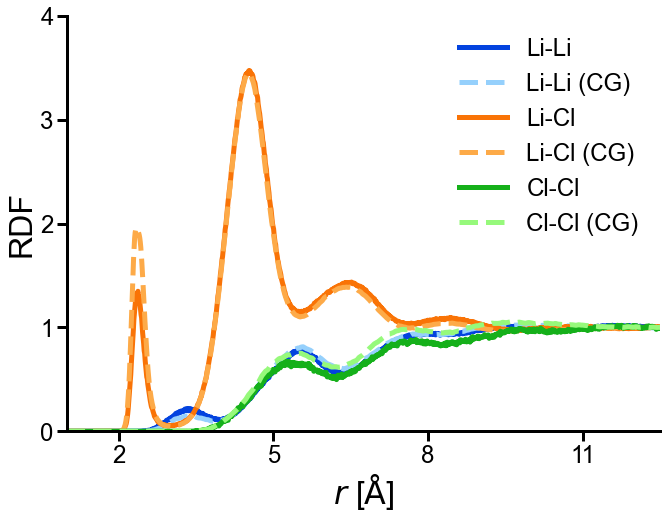

In [92]:
RDFLiCll31p2Mcg15=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/RDF-LiCl-cg15-1p2M-bigbox.dat"))
#    print(RDFLiCll31p2M)
#     Extract columns from data

norm_factors = next((row[1:] for row in RDFLiCll31p2Mcg15 if row[0] == 12.5), None)
normalized_data = [[row[0]] + [row[j] / norm_factors[j-1] for j in range(1, 4)] for row in RDFLiCll31p2Mcg15]
rcg15 = [row[0] for row in normalized_data]
y1cg15 = [row[1] for row in normalized_data]
y2cg15 = [row[2] for row in normalized_data]
y3cg15 = [row[3] for row in normalized_data]


#   RDFLiCll3bonly2p4M=readRDFs(os.path.expanduser("~/Dropbox/Research/Nequip/OsmoticsmPHvirial/RDF-LiCl-l3bonly-2p4M-bigbox.dat"))
#    print(RDFLiCll31p2M)
#     Extract columns from data

#    norm_factors = next((row[1:] for row in RDFLiCll3bonly2p4M if row[0] == 12.5), None)
#    normalized_data = [[row[0]] + [row[j] / norm_factors[j-1] for j in range(1, 4)] for row in RDFLiCll3bonly2p4M]
#    x2p4l3bonly = [row[0] for row in normalized_data]
#    y1p4l3bonly = [row[1] for row in normalized_data]
#    y2p4l3bonly = [row[2] for row in normalized_data]
#    y3p4l3bonly = [row[3] for row in normalized_data]



# Plotting
plt.figure(figsize=(10, 8))
plt.plot(r2p5M, RDFarrnorm1p2[:,0,4], label='Li-Li',  linewidth=5, color=bright_colors[0])
plt.plot(rcg15, y1cg15, label='Li-Li (CG)', linestyle='--', linewidth=5, color=bright_colors[3])
plt.plot(r2p5M, RDFarrnorm1p2[:,1,4], label='Li-Cl',  linewidth=5, color=bright_colors[1])
plt.plot(rcg15, y2cg15, label='Li-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[4])
plt.plot(r2p5M, RDFarrnorm1p2[:,2,3], label='Cl-Cl',  linewidth=5, color=bright_colors[2])
plt.plot(rcg15, y3cg15, label='Cl-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[5])

# Axis ticks
plt.xlim([1, 12.5])
plt.ylim([0, 4])
plt.xticks(np.arange(2,12.01, 3))
plt.yticks(np.arange(0,4.01, 1))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style() 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFLiCll31p2M-cg15comp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()










    

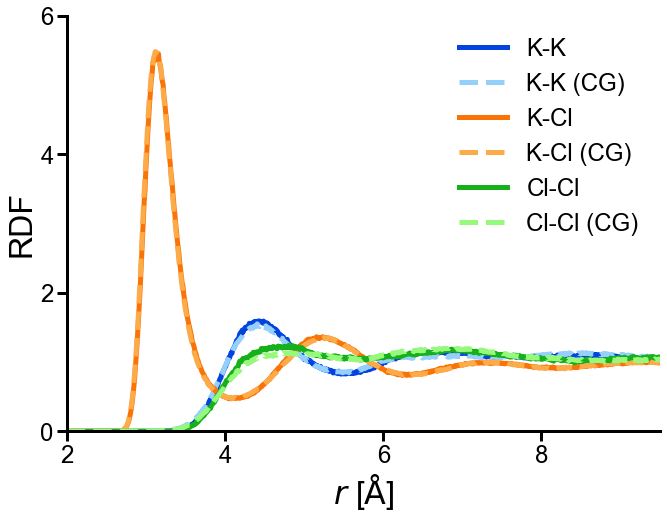

In [93]:

RDFKKkc36p6Mcg1=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/gofrKK-kc3-6p6M-cg1.dat"))
RDFKClkc36p6Mcg1=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/gofrKCl-kc3-6p6M-cg1.dat"))
RDFClClkc36p6Mcg1=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/gofrClCl-kc3-6p6M-cg1.dat"))


# Plotting
plt.figure(figsize=(10, 8))
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,1], label='K-K',  linewidth=5, color=bright_colors[0])
plt.plot(RDFKKkc36p6Mcg1[:,0], RDFKKkc36p6Mcg1[:,1], label='K-K (CG)', linestyle='--', linewidth=5, color=bright_colors[3])
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,2], label='K-Cl',  linewidth=5, color=bright_colors[1])
plt.plot(RDFKClkc36p6Mcg1[:,0], RDFKClkc36p6Mcg1[:,1], label='K-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[4])
plt.plot(RDFkc46p6M[:,0], RDFkc46p6M[:,3], label='Cl-Cl',  linewidth=5, color=bright_colors[2])
plt.plot(RDFClClkc36p6Mcg1[:,0], RDFClClkc36p6Mcg1[:,1], label='Cl-Cl (CG)', linestyle='--', linewidth=5, color=bright_colors[5])

# Axis ticks
plt.xlim([2, 9.5])
plt.ylim([0, 6])
plt.xticks(np.arange(2,9.01, 2))
plt.yticks(np.arange(0,6.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style() 
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/RDFKCll36p6M-cg1comp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()










    

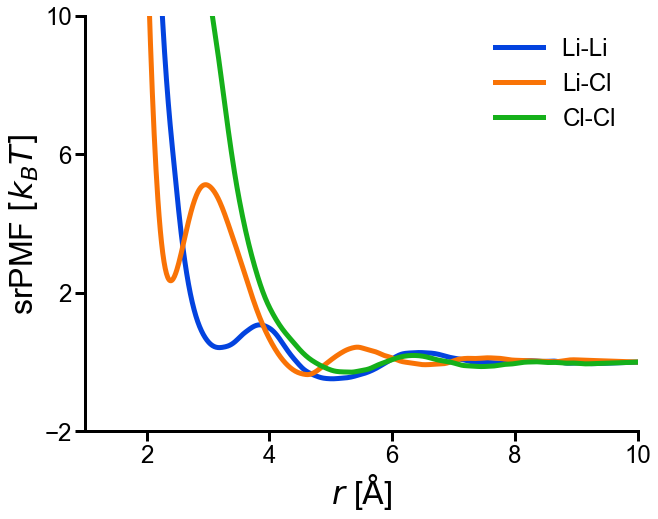

In [94]:


LiCl2BSRPMFscg15=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/LiCl2BSRPMF-cg15.dat"))
r = [row[0] for row in LiCl2BSRPMFscg15]
LiLi = [row[1] for row in LiCl2BSRPMFscg15]
LiCl = [row[2] for row in LiCl2BSRPMFscg15]
ClCl = [row[3] for row in LiCl2BSRPMFscg15]

plt.figure(figsize=(10, 8))
plt.plot(r, LiLi, label='Li-Li ', linewidth=5, color=bright_colors[0])
plt.plot(r, LiCl, label='Li-Cl', linewidth=5, color=bright_colors[1])
plt.plot(r, ClCl, label='Cl-Cl', linewidth=5, color=bright_colors[2])
plt.xlim([1, 10])
plt.ylim([-2, 10])
# Axis ticks
plt.xticks(np.arange(2,10.01, 2))
plt.yticks(np.arange(-2.0,10.01, 4))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('srPMF $[k_BT]$', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)

set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/LiCl2BSRPMF.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()


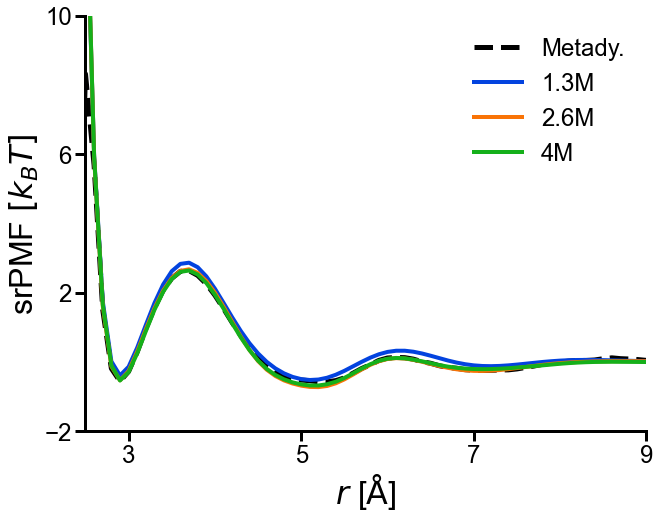

In [95]:
LiCl2BSRPMFscg15=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/NaClsrPMF_NequIP4M.dat"))
LiCl2BSRPMFscg152=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/NaClPMF_NequIP2p6M.dat"))
LiCl2BSRPMFscg153=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/NaClsrPMF_NequIP1p3M.dat"))
LiCl2BSRPMFscg154=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/NaClPMF_MTset.dat"))
r = [row[0] for row in LiCl2BSRPMFscg15]
NaClsrPMFMT = [row[2] for row in LiCl2BSRPMFscg154]
NaClsrPMF1p3M = [row[2] for row in LiCl2BSRPMFscg153]
NaClsrPMF2p6M = [row[2] for row in LiCl2BSRPMFscg152]
NaClsrPMF4M = [row[2] for row in LiCl2BSRPMFscg15]



plt.figure(figsize=(10, 8))
plt.plot(r, NaClsrPMFMT, label='Metady.', linewidth=5, linestyle='--',color='black')
plt.plot(r, NaClsrPMF1p3M, label='1.3M', linewidth=4, color=bright_colors[0])
plt.plot(r, NaClsrPMF2p6M, label='2.6M', linewidth=4, color=bright_colors[1])
plt.plot(r, NaClsrPMF4M, label='4M', linewidth=4, color=bright_colors[2])
plt.xlim([2.5, 9])
plt.ylim([-2, 10])

# Axis ticks
plt.xticks(np.arange(3,9.01, 2))
plt.yticks(np.arange(-2,10.01,4))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('srPMF $[k_BT]$', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/pythonNaClsrPMFmetavsNequIp.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()

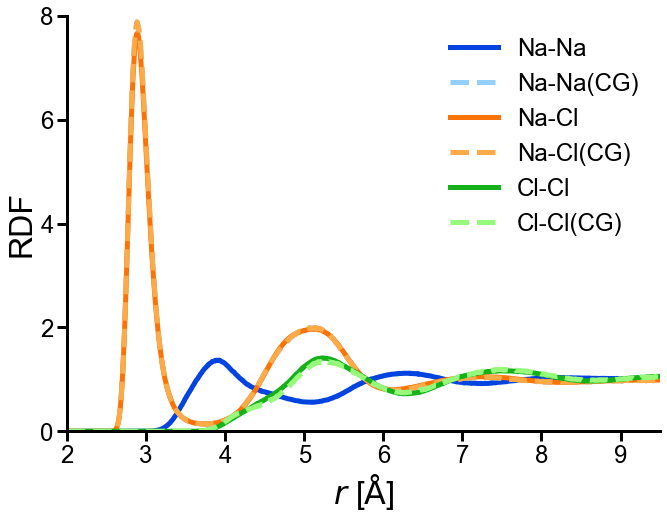

In [96]:
RDFKK=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-NaRDFCMD4Mcut15Set.dat"))
RDFKCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDFCMD4Mcut15Set.dat"))
RDFClCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDFCMD4Mcut15Set.dat"))
RDFKK2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDFNNPMD4M.dat"))
RDFKCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDFNNPMD4M.dat"))
RDFClCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDFNNPMD4M.dat"))


# Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(RDFKK[:,0],RDFKK[:,1], label='Na-Na', linewidth=5, color=bright_colors[0])
plt.plot(RDFKK2[:,0],RDFKK2[:,1], label='Na-Na(CG)', linewidth=5, linestyle='--', color=bright_colors[3])
plt.plot(RDFKCl[:,0],RDFKCl[:,1], label='Na-Cl', linewidth=5, color=bright_colors[1])
plt.plot(RDFKCl2[:,0],RDFKCl2[:,1], label='Na-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[4])
plt.plot(RDFClCl[:,0],RDFClCl[:,1], label='Cl-Cl', linewidth=5, color=bright_colors[2])
plt.plot(RDFClCl2[:,0],RDFClCl2[:,1], label='Cl-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[5])

# Set font properties
# Axis ticks
plt.xlim([2, 9.5])
plt.ylim([0, 6.1])
plt.xticks(np.arange(2,9.5, 1))
plt.yticks(np.arange(0,8.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/pythonRDF4MCMDvsCGMD.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()

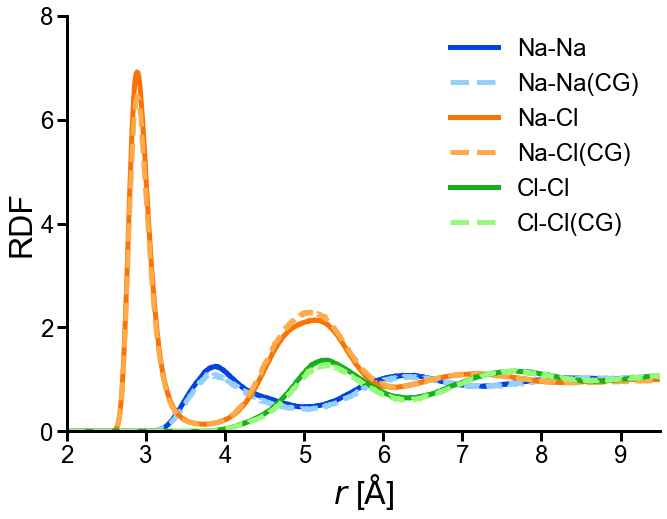

In [97]:
RDFKK=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-NaRDF2p6MCMDR3.dat"))
RDFKCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDF2p6MCMDR3.dat"))
RDFClCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDF2p6MCMDR3.dat"))
RDFKK2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-NaRDFNNPMD2p6M50angstrom.dat"))
RDFKCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDFNNPMD2p6M50angstrom.dat"))
RDFClCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDFNNPMD2p6M50angstrom.dat"))


# Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(RDFKK[:,0],RDFKK[:,1], label='Na-Na', linewidth=5, color=bright_colors[0])
plt.plot(RDFKK2[:,0],RDFKK2[:,1], label='Na-Na(CG)', linewidth=5, linestyle='--', color=bright_colors[3])
plt.plot(RDFKCl[:,0],RDFKCl[:,1], label='Na-Cl', linewidth=5, color=bright_colors[1])
plt.plot(RDFKCl2[:,0],RDFKCl2[:,1], label='Na-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[4])
plt.plot(RDFClCl[:,0],RDFClCl[:,1], label='Cl-Cl', linewidth=5, color=bright_colors[2])
plt.plot(RDFClCl2[:,0],RDFClCl2[:,1], label='Cl-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[5])

# Set font properties
# Axis ticks
plt.xlim([2, 9.5])
plt.ylim([0, 6.1])
plt.xticks(np.arange(2,9.5, 1))
plt.yticks(np.arange(0,8.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()    
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/pythonRDF2p6MCMDvsCGMD.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()

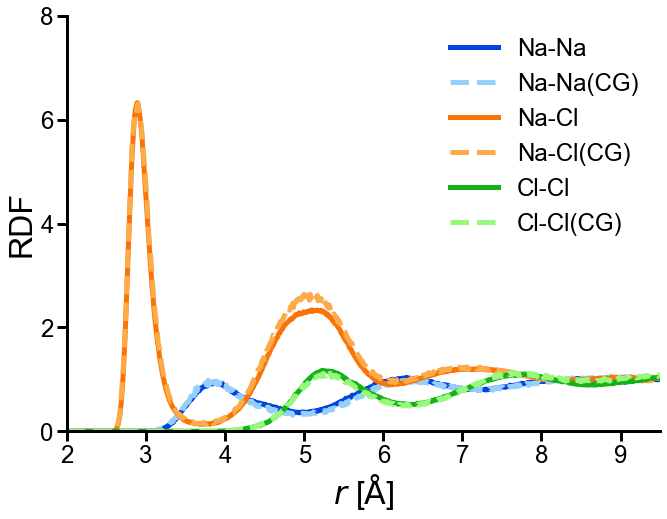

In [98]:
RDFKK=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-NaRDF1p3MCMD.dat"))
RDFKCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDF1p3MCMD.dat"))
RDFClCl=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDF1p3MCMD.dat"))
RDFKK2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-NaRDFNNPMD1p3MF4M.dat"))
RDFKCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Na-ClRDFNNPMD1p3MF4M.dat"))
RDFClCl2=readRDFs(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Analysis/Data/Cl-ClRDFNNPMD1p3MF4M.dat"))


# Plotting
plt.figure(figsize=(10, 8))
 
plt.plot(RDFKK[:,0],RDFKK[:,1], label='Na-Na', linewidth=5, color=bright_colors[0])
plt.plot(RDFKK2[:,0],RDFKK2[:,1], label='Na-Na(CG)', linewidth=5, linestyle='--', color=bright_colors[3])
plt.plot(RDFKCl[:,0],RDFKCl[:,1], label='Na-Cl', linewidth=5, color=bright_colors[1])
plt.plot(RDFKCl2[:,0],RDFKCl2[:,1], label='Na-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[4])
plt.plot(RDFClCl[:,0],RDFClCl[:,1], label='Cl-Cl', linewidth=5, color=bright_colors[2])
plt.plot(RDFClCl2[:,0],RDFClCl2[:,1], label='Cl-Cl(CG)', linewidth=5, linestyle='--', color=bright_colors[5])

# Set font properties
# Axis ticks
plt.xlim([2, 9.5])
plt.ylim([0, 6.1])
plt.xticks(np.arange(2,9.5, 1))
plt.yticks(np.arange(0,8.01, 2))
plt.xlabel('$r$ [$\mathrm{\AA}}$]', fontsize=32)
plt.ylabel('RDF', fontsize=32)
plt.legend(loc='upper right', fontsize=24, frameon=False)
set_plot_style()    
plt.savefig(os.path.expanduser("~/Dropbox/Writing/Papers/LiKClBr/Images/pythonRDF1p3MCMDvsCGMD.eps"), format='eps', dpi=1000)  # Adjust DPI as needed
plt.show()